<a href="https://colab.research.google.com/github/bmarzban/PPG/blob/master/PPG_Biostrap_pyheart_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install heartpy

     |████████████████████████████████| 1.0 MB 13.0 MB/s 


instally the heartpy library
and importingt the dependencies and the data files:


In [3]:
import numpy as np
from numpy import diff
import heartpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks
from scipy.signal import resample

import os
from google.colab import drive
from google.colab import files  
#drive.mount('/drive')
mypath = "/content/drive/MyDrive/Daxor/PycharmProjects/PPGProject"
os.chdir('/content/drive/MyDrive/Daxor/PycharmProjects/PPGProject')
## dataset = pd.read_csv("data.csv")
#acc_data = pd.read_csv("20211101.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20211101.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211101.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20211101.biometrics.csv") #Read data from CSV datafile

#acc_data = pd.read_csv("20211104.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20211104.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211104.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20211104.biometrics.csv") #Read data from CSV datafile

acc_data = pd.read_csv("20220104.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20220104.PPG.csv") #Read data from CSV datafile
PPG_data = pd.read_csv("20220104.csv") #Read data from CSV datafile
biometrics_data = pd.read_csv("20220104.biometrics.csv") #Read data from CSV datafile

#acc_data = pd.read_csv("20211228.wristband_accel.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211228.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211228.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20211228.biometrics.csv") #Read data from CSV datafile

#acc_data = pd.read_csv("20211108.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20211228.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211108.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20211108.biometrics.csv") #Read data from CSV datafile

#acc_data = pd.read_csv("20211218.wristband_accel.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211218.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211218.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20211218.biometrics.csv") #Read data from CSV datafile

#acc_data = pd.read_csv("20220223.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20220223.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20220223.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20220223.biometrics.csv") #Read data from CSV datafile

#acc_data = pd.read_csv("20220224.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20220223.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20220224.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20220224.biometrics.csv") #Read data from CSV datafile


Now we need to know the sampling rate
The sampling rate is the one measure to rule them all. It is used to compute all others.
Let's look at the format of the timer column to see what we're working with.

So, the format seems to be up to ns percision in time'


In [4]:

# The PPG data time vector is the unit of the nano second (ns)
nsec_to_sec = 1e-9;
msec_to_sec = 1e-3;
sec_to_min = 1/60;
# The accelartion data time vector is the unit of the mili second (ms)

# extracting out the sampling frequency in both accelartion data and ppg data

# sampling rate is in Hz, meaning how often we read the data or how many times we read a data on second
# Low pas filter, highpass filter, we need some, or band width filter we need some sampling rate/frequency here but this is how it works:
PPG_time = PPG_data.ts - PPG_data.ts[0]
PPG_sample_freq =1/ np.mean(diff(PPG_time[1:170])*nsec_to_sec)


acc_time = acc_data.ts - acc_data.ts[0]
acc_sample_freq =1/ np.mean(diff(acc_time[1:100])*msec_to_sec)



print('PPG sampling rate is: %.3f Hz' %PPG_sample_freq)
print('ACC sampling rate is: %.3f Hz' %acc_sample_freq)


PPG sampling rate is: 42.000 Hz
ACC sampling rate is: 10.000 Hz


That's an okay sampling rate for PPG data low. ususally higher than 50 Hz sampling rate are not availble in the commercial PPG wearables because these are consuming lots of battry power.

The sample rate is quite low but to conserve power this is what many smart watches work with. For determining the BPM this is just fine, but any heart rate variability (HRV) measures are likely not going to be super accurate. Depending on your needs it may still be fine, though.

A second consideration with sampling rate is whether it's stable or not. Many devices including smart watches do many things at once. They run an OS that has other tasks besides measuring heart rate, so when measuring at 10Hz, the OS might not be ready exactly every 100ms to get a measurement. As such, the sampling rate might vary. Let's visualise this.

**solutions to random sampling rate is resampling the data**

You could of course interpolate and resample the signal so that it has an exact sampling rate but the effects on computed measures are likely minimal. For now let's just continue on.

The first thing to note is that amplitude varies dramatically. Let's run it through a bandpass filter and take out all frequencies that definitely are not heart rate.

We'll take out frequencies below 0.7Hz (42 BPM) and above 3.5 Hz (210 BPM).

Still low quality but at least the heart rate is quite visible now!


Let's use a for loop and filter all the data segments
**removing the missing values and replacing that with zeros. Here we can afford getting rid of some portion of the time series cause we have alot of data, but if it's not possible we can interpolate those values**
- converting data frame values to numpy array
- converting the time vector from ns to min

In [5]:

time = ((PPG_time)*sec_to_min*nsec_to_sec).to_numpy()

#inverse the signals cause it's inversed at the device recoding level:
ir_filt = - PPG_data.ir_filt.to_numpy()
red_filt = - PPG_data.red_filt.to_numpy()
red_raw = - PPG_data.red.to_numpy()
ir_raw = - PPG_data.ir.to_numpy()
#missing pieces! Let's replace
red = np.nan_to_num(red_raw)
ir = np.nan_to_num(ir_raw)


The time vecto in this data sets is discontnious time vector. meaning there will be many time points that the time vector has also gaps in it, therefore the data is collected in a segment way and not continious. This is good also for saving the memory and reduing the computational time.

**writing a simple loop to mark the step rise in the time, so basically the idea is the same as the peak finder but here we just compare the k element with elements k-1 and k-2 and not k+1 ... in a for loop**


In [6]:
# writing a simple code to mark the step rise in the time
# so basically the idea is the same as the peak finder but here we just compare the k element with elements k-1 and k-2 and not k+1 ... in a for loop
length_vec = np.arange(2, len(time)-1, 1)
#length_vec = np.arange(2, len(time), 1)

recording_episode_counts = 0
#time_jump_threshold = 0.00039682; # units in minute since we converted the time to minute earlier today
time_jump_threshold = 0.01;
collect_start_idx =[]
for k in length_vec:
  if (time[k]> time[k-1] and (time[k]- time[k-1]) >time_jump_threshold) :
   # print(k)
    recording_episode_counts = recording_episode_counts + 1

recording_episode_counts_total = recording_episode_counts
collect_start_idx = np.zeros(recording_episode_counts) 
recording_episode_counts = 0

for k in length_vec:
  if (time[k]> time[k-1] and (time[k]- time[k-1]) >time_jump_threshold) :
    #print(k)
    recording_episode_counts = recording_episode_counts + 1
    collect_start_idx [recording_episode_counts-1] = k


**identifying jumps in time vector**


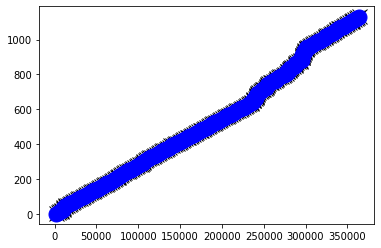

total time recorded by the device in minute
1134.0222222214666
total segments or episodes recorded by the device:
226
the longest time the device did not record anything in minute:
14.0


In [7]:
plt.figure()
plt.plot( np.arange(0, len(time),1),time,'xy')

collect_start_idx = collect_start_idx.astype(int)

plt.plot(collect_start_idx,time[collect_start_idx],'x',color='black', markersize=15, linewidth=5)
#plt.xlim([350000,364000])
#plt.ylim([0,80])
# plotting the end times
collect_end_idx = collect_start_idx - 1
plt.plot(collect_start_idx,time[collect_end_idx],'o',color='blue', markersize=15, linewidth=10)
plt.show()

# printing the total time recorded by the device
print('total time recorded by the device in minute')
print(np.amax(time))
# printing total segments/episodes recorded by the device
print('total segments or episodes recorded by the device:')
print(recording_episode_counts)
# check what was the longest time the device were not recording anything
print('the longest time the device did not record anything in minute:')
print(np.amax(diff(time[collect_start_idx])))
#print(diff(collect_start_idx))

**filtering the raw PPG signals**


So here is why I need to do a segment separation If you will. It means that apparently, and it need to be checked, but if our recording segment is short the filtering process fails. That means we need to exclude that from our filtering. So the way I do that I would say if the segment length is smaller than like 20 or something, we just exclude that. 
we are excludingt the recoding as well


In the above the difference between the length signal of the red signal and the filtered appended segment by segment raw signal is that the last segment is not counted in our simulations
 

I need to repeat the above calculation with the distance peak functiona and with the negative sign of the filter which is the true signal:


In [8]:
# so the next thing is actually plotting the HR versus time and compare that with the plot from people in biostrap
  #Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.

num_of_recording_segments = np.arange(1, recording_episode_counts_total+1, 1)
if collect_start_idx[0] != 0:
   collect_start_idx =np.append(0,collect_start_idx)

red_filt_pyheart =np.zeros(1)
#red_filt_pyheart =[]
ir_filt_pyheart =np.zeros(1)
for j in num_of_recording_segments:
  if collect_start_idx[j]-collect_start_idx[j-1] < 20:
     filtered_seg_red = np.zeros(collect_start_idx[j]-collect_start_idx[j-1])
     filtered_seg_ir = np.zeros(collect_start_idx[j]-collect_start_idx[j-1])
  else:
     filtered_seg_red = hp.filter_signal(red[collect_start_idx[j-1]:collect_start_idx[j]], [0.7, 3.5], sample_rate=PPG_sample_freq, 
                            order=3, filtertype='bandpass')
     filtered_seg_ir = hp.filter_signal(ir[collect_start_idx[j-1]:collect_start_idx[j]], [0.7, 3.5], sample_rate=PPG_sample_freq, 
                            order=3, filtertype='bandpass')
  red_filt_pyheart= np.append(red_filt_pyheart,filtered_seg_red)
  ir_filt_pyheart= np.append(ir_filt_pyheart,filtered_seg_ir)



# replacing the nan data with zero 
spo2 = biometrics_data.spo2.replace(0,np.nan)
HR = biometrics_data.bpm.replace(0,np.nan)
HRV = biometrics_data.hrv.replace(0,np.nan)

HRnp = HR.to_numpy()
HRVnp = HRV.to_numpy()



plotting a segment of the data and compare DAXOR filtered version of the signal and BioStrap Filtered version of the signal

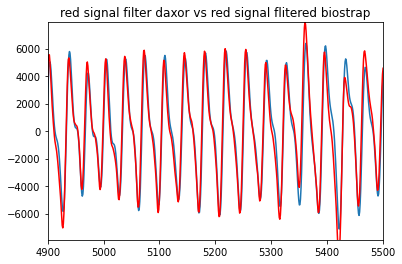

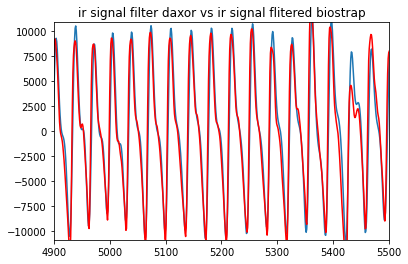

In [9]:
plt.figure()
plt.title('red signal filter daxor vs red signal flitered biostrap')
plt.plot(red_filt_pyheart)
plt.plot(red_filt,'r')
plt.xlim([41900,42500])
plt.xlim([4900,5500])
plt.ylim([-7900,7900])

plt.figure()
plt.title('ir signal filter daxor vs ir signal flitered biostrap')
plt.plot(ir_filt_pyheart)
plt.plot(ir_filt,'r')
plt.xlim([41900,42500])
plt.xlim([4900,5500])
plt.ylim([-10900,10900])
plt.show()

Okay it’s done and now let’s move to next target. So I have signal that can predict the HR for all times, I can just rplace zero HR with nan for plotting purposes ,
Now let’s build the DQM
DQM1 is the length of the recordings. Recordings less than 10  seconds gonna be excluded an reported as bad quality well the recording  sampling rate is 42 Hz, therefore we have the following number of sample/threshold for short recordings, length of the diff less than 42*10 = 420 we will call it off the chart
We figured out what is DQM1 is let’s just make it happen
 


We aslo do the calculations for both signals


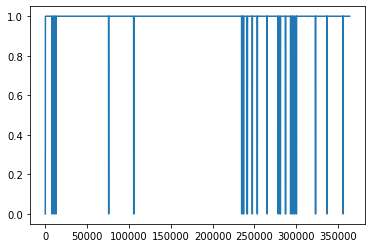

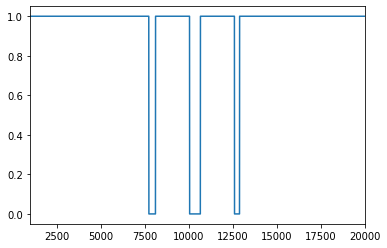

(array([     0,   7737,   7738, ..., 356042, 356043, 356044]),)

In [10]:
# this is the veru first Data Quality Metric (DQM) which is the lenght of eache recording segment
# if it's less than 10 second, we will ignore it and treat it as not recorded signal

PPG_sample_freq = PPG_sample_freq.astype(int)

segment_length_threshold = 10*PPG_sample_freq
#DQM_signal =[]
DQM_signal = np.zeros(1)
for j in num_of_recording_segments:
  if collect_start_idx[j]-collect_start_idx[j-1] < segment_length_threshold:
     DQM_segment_temp = np.zeros(collect_start_idx[j]-collect_start_idx[j-1])
  else:
     DQM_segment_temp = np.ones(collect_start_idx[j]-collect_start_idx[j-1])

  DQM_signal= np.append(DQM_signal,DQM_segment_temp)

plt.figure()
plt.plot(DQM_signal)
plt.show()

# zooming to the first recordings
plt.figure()
plt.plot(DQM_signal)
plt.xlim([1000,20000])
plt.show()

np.where(DQM_signal<1)
#now let's use this DQM into our HR prediction and then we will add more DQM_criteria

after obtaining the DQM I can simply adjust every signal by rejecting/ignoring the zero DQM. with the following metrics. 
I can use the element wise product of the signal with the DQM and not the dot product.

- I can also go ahead and calculate the slope right after the peak for every segment. 
- another thing I can add is actually reject the segments that have high volatility:
I can come up with a variable and a threshold for that. (it could be a normalized version nd has to distinguish between the following signals )

- I can do an envelope kind of things for each segment and comeup with envelope variation metriac and reject that signal!
- Another thing I can do is actually choose a middle window or a window in each signal that has lower envelope variation:
For instance every segment is divided to 3 or 4 slice I can use the best slice for HR or SPO2 or extraction of slope,


for the envelop of each segment, we just find the peak of the signal and the the reverse signal(signal multiplied * -1) which is basically the mean of the signal

We make a function to plot the segments by giving the segment numbers


70.39834693570617
Heart rate for the segment


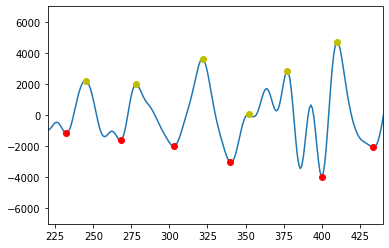

In [11]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
seg_number =6
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')
plt.xlim([220,440])
plt.ylim([-7000,7000])
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

plotting the upper enevelope and lower envelope with a dashline 

(-7000.0, 7000.0)

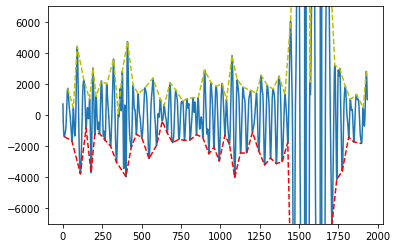

In [12]:
# plotting the upper envelope and lowe envelope
plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'--y')
plt.plot(peaks_negative,segment[peaks_negative],'--r')
#plt.xlim([0,840])
plt.ylim([-7000,7000])

CALCULATE THE VOLATILITY OF THE UPPER ENEVELOPE AND LOWER ENVELOPE

In [13]:
#segment volatility

print(np.amax(segment[peaks_negative]))
print(np.amin(segment[peaks_negative]))
print(np.amax(segment[peaks_positive]))
print(np.amin(segment[peaks_positive]))
print(np.std(segment[peaks_positive]))
print(np.std(segment[peaks_negative]))
print(np.abs(np.amax(segment[peaks_positive]))/np.abs(np.amin(segment[peaks_positive])))
print(np.abs(np.amin(segment[peaks_negative]))/np.abs(np.amax(segment[peaks_negative])))

segment_highest_peak = np.amax(segment[peaks_positive])
segment_lowest_peak = np.amin(segment[peaks_positive])
segment_highest_negative_peak= np.amax(segment[peaks_negative])
segment_lowest_negative_peak= np.amin(segment[peaks_negative])
high_low_ratio_positive = segment_highest_peak/segment_lowest_peak
high_low_ratio_negative = segment_highest_negative_peak/segment_lowest_negative_peak

-387.13722807489415
-121263.9988811889
289611.8317223275
41.450408594737496
53533.17179063837
23723.939812221164
6986.947572794164
313.23259580122226


now let's put this into a metric by  fitting an straight line to the envelope and see if the slope is small and the fitting error is low therefore we have a good segment. Later on this metric can be used it can be use for a slice within and see how far they change:
fitting error is important
r square is also the correlation coefficient can also works as a kind of slope parameter
these two parameters are in

0.055334765964893104


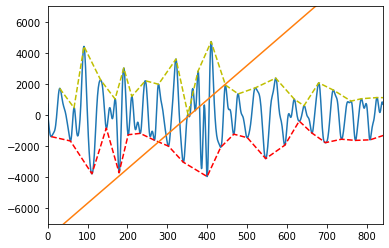

In [14]:
# two way works, one is actually using Python numpy and one is scipy stats module
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(peaks_positive, segment[peaks_positive])
#slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(peaks_positive, np.ones(len(peaks_positive)))

# plotting the upper envelope and lowe envelope
plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'--y')
plt.plot(peaks_negative,segment[peaks_negative],'--r')
plt.plot(peaks_positive,slope*peaks_positive+intercept)
print(r_value**2)
plt.xlim([0,840])
plt.ylim([-7000,7000])
plt.show()

**make a for loop** for all the segments

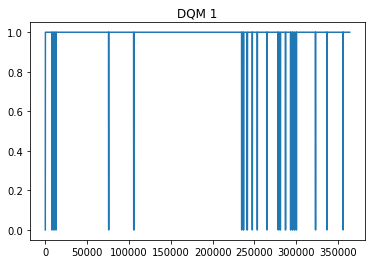

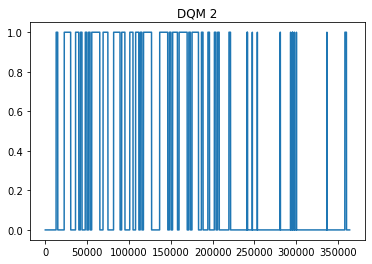

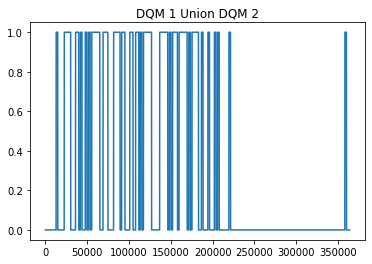

(array([ 12886,  12887,  12888, ..., 359910, 359911, 359912]),)

In [15]:
# this is the veru first Data Quality Metric (DQM#2) which is the volatility of the segment
# if the ratio of the max and min of the envelop is 0.5 and the less we assign number zero to that segment, 
# we will ignore it and treat it as not recorded signal

PPG_sample_freq = PPG_sample_freq.astype(int)

segment_length_threshold = 10*PPG_sample_freq
#DQM_signal =[]
DQM2_signal = np.zeros(1)
for kk in num_of_recording_segments:
  start_idx = collect_start_idx
  signal = red_filt_pyheart
  segment = signal[start_idx[kk-1]:start_idx[kk]]
  
 # if np.mean(segment) < 0.001:
  #  DQM2_segment_temp = np.zeros(collect_start_idx[kk]-collect_start_idx[kk-1])
   # print(len(DQM2_segment_temp))
    #DQM2_signal= np.append(DQM2_signal,DQM2_segment_temp)
    #continue

  peaks_positive, _ = find_peaks(segment, height=0,distance =20)
  peaks_negative, _ = find_peaks(-segment, height=0,distance =20)
  
  if len(peaks_negative) == 0:
    segment_highest_peak = 1000
    segment_lowest_peak = 1
    segment_highest_negative_peak = 1
    segment_lowest_negative_peak =100
  else:
    segment_highest_peak = np.amax(segment[peaks_positive])
    segment_lowest_peak = np.amin(segment[peaks_positive])
    segment_highest_negative_peak= np.amax(segment[peaks_negative])
    segment_lowest_negative_peak= np.amin(segment[peaks_negative])
  high_low_ratio_positive = segment_highest_peak/segment_lowest_peak
  high_low_ratio_negative = segment_highest_negative_peak/segment_lowest_negative_peak
  if high_low_ratio_positive > 10:
     #print('pos')
     DQM2_segment_temp = np.zeros(collect_start_idx[kk]-collect_start_idx[kk-1])
  elif high_low_ratio_negative<0.1:
     #print('neg')
     DQM2_segment_temp = np.zeros(collect_start_idx[kk]-collect_start_idx[kk-1])
  else: 
     DQM2_segment_temp = np.ones(collect_start_idx[kk]-collect_start_idx[kk-1])
  DQM2_signal= np.append(DQM2_signal,DQM2_segment_temp)

plt.figure()
plt.plot(DQM_signal)

plt.title('DQM 1')
# zooming to the first recordings
plt.figure()
plt.plot(DQM2_signal)
#plt.xlim([0,200000])
plt.title('DQM 2')

np.where(DQM2_signal<1)

plt.figure()
DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)
plt.plot(DQM_signal_all)
plt.title('DQM 1 Union DQM 2')

plt.show()
# convert zero to nan and then plot 
np.where(DQM_signal_all>0)
#segment finder:
#now let's use this DQM into our HR prediction and then we will add more DQM_criteria

# Here I am calculting the slopes and the plotting those
An easy way to calculate the slope is just use the max peaks and the min peaks to identify the slope of the line by fitting using line regress. It might be time consuming but at this point we don’t need speed  scipy width of each peak 

58.66528911308576
Heart rate for the segment


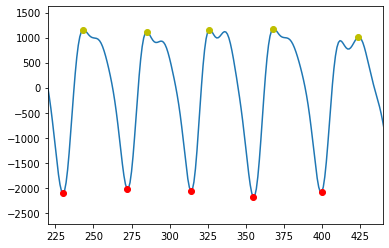

In [16]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
seg_number = 54
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([220,440])
#plt.ylim([-7000,7000])

time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

calucate the slopes using the max and minimum 




using for loop to calculate all the slopes in the segment


now adding a for loop to calculate the slope for a short period after the peak and plot that:


Fixing the the peak point or the min point indexing in the for loop:


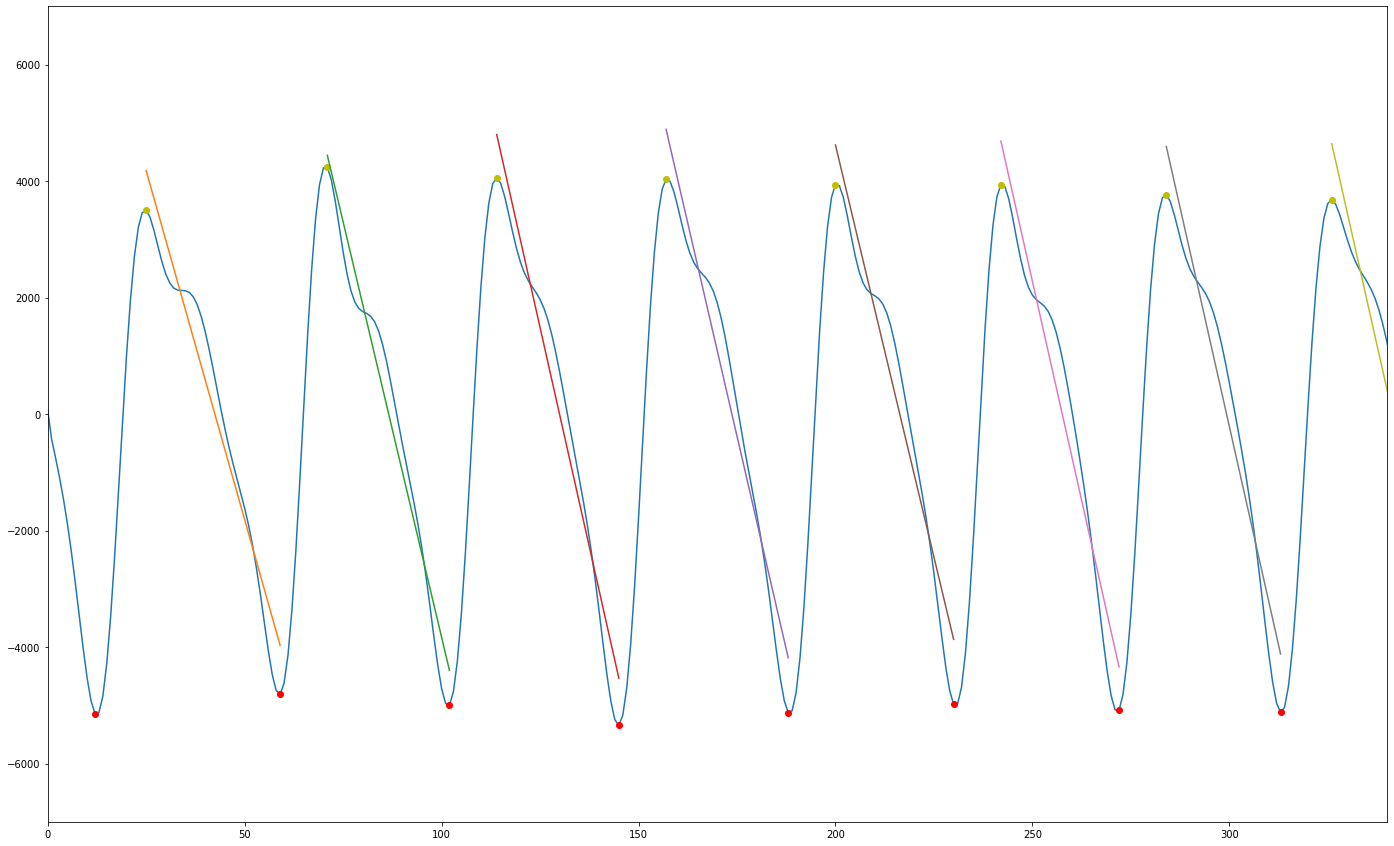

61.27263529588958
Heart rate for the segment


In [17]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 72

start_idx = collect_start_idx
signal = red_filt_pyheart
#signal = red_filt

segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(24,15))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,340])
plt.ylim([-7000,7000])

for i in np.arange(1,len(peaks_positive)-1, 1):
  if peaks_positive[0]>peaks_negative[0]:
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]])
    slope_up = np.array([segment[peaks_positive[i-1]], segment[peaks_negative[i]]])
  elif peaks_positive[0]<peaks_negative[0]:
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i]])
    #converting the list to array and then plot
    slope_up = np.array([segment[peaks_positive[i]], segment[peaks_negative[i]]])
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

calculating first half part of the down slope and plotting the extended line

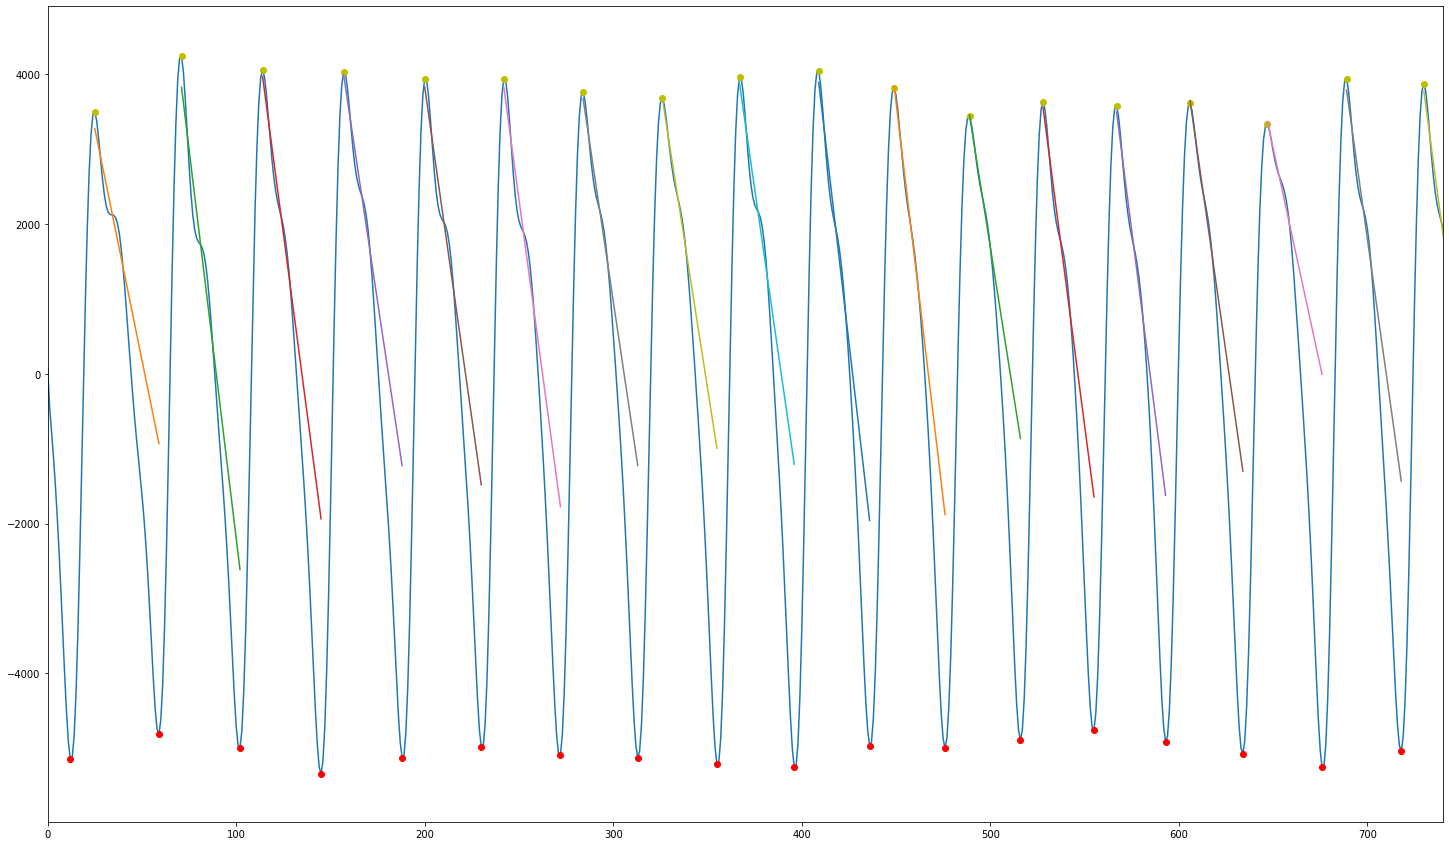

61.27263529588958
Heart rate for the segment


In [18]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 72
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(25,15))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,740])
#plt.ylim([-7000,7000])

for i in np.arange(1,len(peaks_positive)-1, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/2))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]])
    slope_up = np.array([segment[peaks_positive[i-1]], segment[peaks_negative[i]]])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/2))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i]])
    #converting the list to array and then plot
    slope_up = np.array([segment[peaks_positive[i]], segment[peaks_negative[i]]])
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

calculating first %25 part of the down slope and plotting without the extended slope 




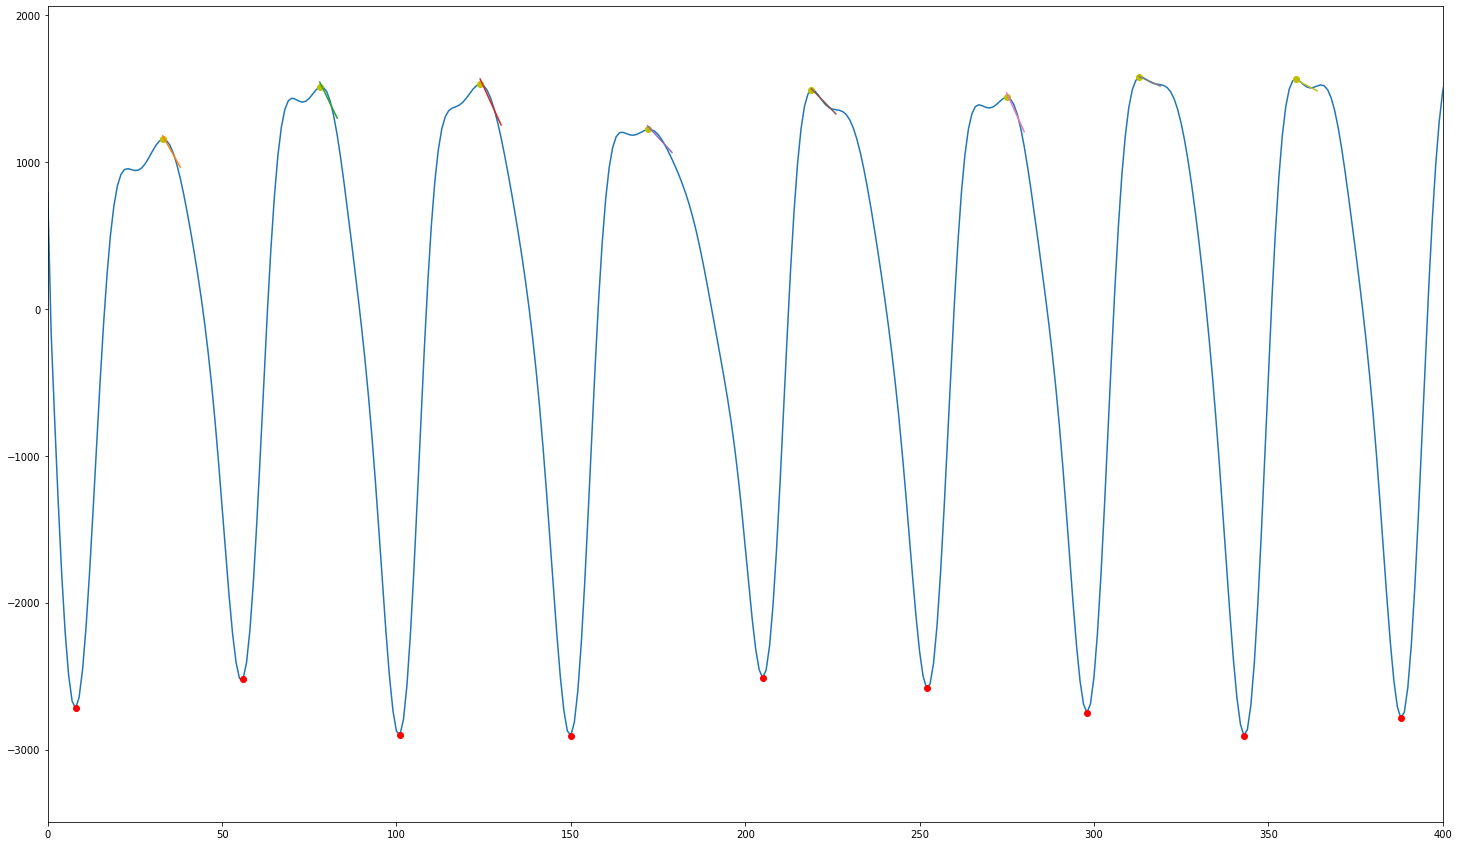

53.450596747478144
Heart rate for the segment


In [19]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 80
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(25,15))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,400])
#plt.ylim([-2500,1900])

for i in np.arange(1,len(peaks_positive)-1, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

`applying the DQM1 mattrix for the length of the recorded segment - rejecting the short records`

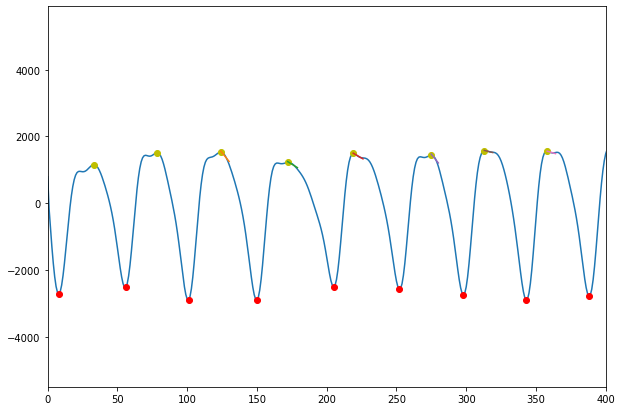

mean slope for the segment:
-29.974511322274125
53.450596747478144
Heart rate for the segment


In [20]:
from numpy.core.defchararray import multiply
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 80
# here we multiply the the DQM1 to the data:
red_filt_pyheart_DQM1 = np.multiply(red_filt_pyheart,DQM_signal)
start_idx = collect_start_idx
#signal = red_filt_pyheart
signal= red_filt_pyheart_DQM1
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(10,7))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,400])
plt.ylim([-5500,5900])
slope_segment_temp = []
# here we start from the third element of the segment to the last -4
for i in np.arange(3,len(peaks_positive)-4, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  slope_segment_temp  = np.append(slope_segment_temp,slope)
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
print('mean slope for the segment:')
print(np.mean(slope_segment_temp))
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

**applying** the DQM2 mattrix for the length of the recorded segment - rejecting the segments with volatile signal qualtiy records ** **bold text**bold text**



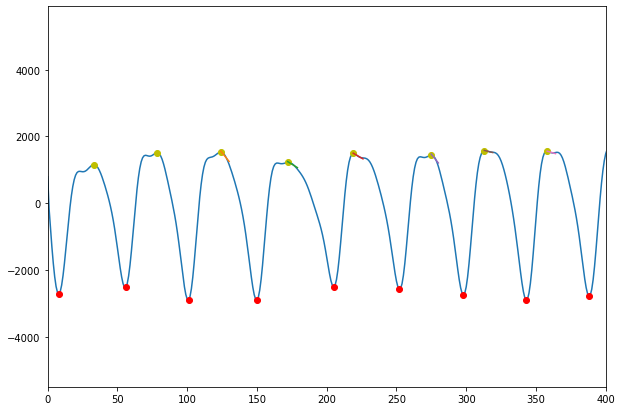

mean slope for the segment:
-29.974511322274125
53.450596747478144
Heart rate for the segment


In [21]:
from numpy.core.defchararray import multiply
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 80
# here we multiply the the DQM1 to the data:
DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)
start_idx = collect_start_idx
#signal = red_filt_pyheart
signal= red_filt_pyheart_DQM_all
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(10,7))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,400])
plt.ylim([-5500,5900])
slope_segment_temp = []

# here we start from the third element of the segment to the last -4
for i in np.arange(3,len(peaks_positive)-4, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  slope_segment_temp  = np.append(slope_segment_temp,slope)
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
print('mean slope for the segment:')
print(np.mean(slope_segment_temp))
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

We see the value of the slope changes, this is mainly becuase the value of the amplitude changes a lot, 
we can see that we can normalize these signals:
now for nomalizing we have different options:
-1 normalizing wrt mean value of the upper envelope
-2 normalzing wrt uppper value, of the beat it self. 
-3 normalizing with respect to max of the segment

First we scale the data between zero and 1024 and then calculate the slope:

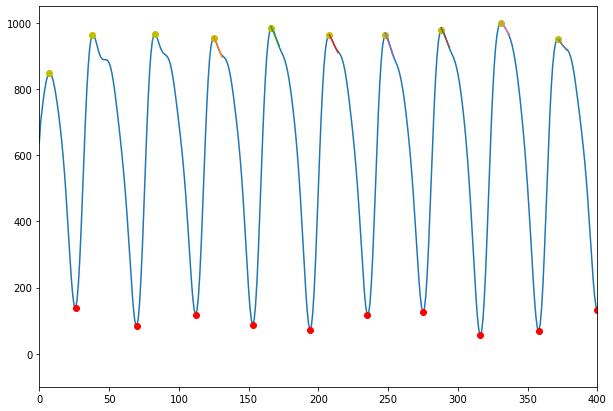

mean slope for the segment:
-7.015522604191928
Heart rate for the segment
58.66528911308794
Slope normalized by Heart rate for the segment
-11.958557965457635


In [22]:
# here we normalize it wrt to the maximum of each beat to see what is the slope:
# well this is fun, I need to come up with the algorithm to normalise it beat by beat
#let's first just scale using the pyheart function:
from numpy.core.defchararray import multiply
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
#11 16 17 18 19 23 24 26 29 31 33 34 35 36 40
seg_number =40
# here we multiply the the DQM1 to the data:
DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)
start_idx = collect_start_idx
#signal = red_filt_pyheart
signal= red_filt_pyheart_DQM_all
segment_nonscaled = signal[start_idx[seg_number-1]:start_idx[seg_number]]
segment = hp.scale_data(segment_nonscaled)
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
plt.figure(figsize=(10,7))
#plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(segment)
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,400])
plt.ylim([-100,1050])
slope_segment_temp = []

# here we start from the third element of the segment to the last -4
for i in np.arange(3,len(peaks_positive)-4, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    #print( slope_up)
    #print( slope_up_idx)
    if len(slope_up_idx) == 0:
      continue
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  slope_segment_temp  = np.append(slope_segment_temp,slope)
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
print('mean slope for the segment:')
print(np.mean(slope_segment_temp))
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print('Heart rate for the segment')
print(HR_mean_segment)
print('Slope normalized by Heart rate for the segment')

print(np.mean(slope_segment_temp)/HR_mean_segment*100)


normalizing the slope with respect to HR in that segment, means that if we have higher HR the slope kind of changes as a function of HR so we need to take that into account

we do a for loop and plot the slope for all the segments that 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


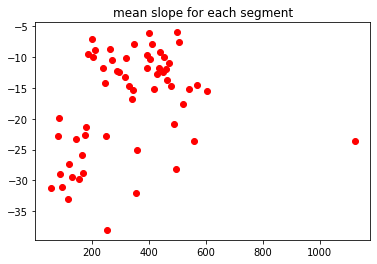

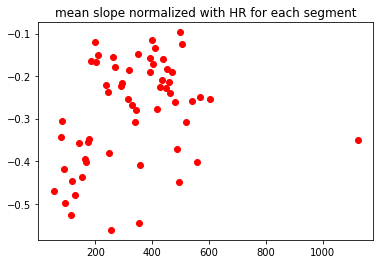

In [23]:
# here we normalize it wrt to the maximum of each beat to see what is the slope:
# well this is fun, I need to come up with the algorithm to normalise it beat by beat
#let's first just scale using the pyheart function:
slope_segment_all =[]
slope_norm_hr_segment_all =[]
for kk in num_of_recording_segments:
  #segment plotter function
  #def segment_plotter(seg_number,start_idx,signal):
  #11 16 17 18 19 23 24 26 29 31 33 34 35 36 40
  #seg_number = 40
  seg_number = kk
 
  # here we multiply the the DQM1 to the data:
  DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

  red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)
  start_idx = collect_start_idx
  #signal = red_filt_pyheart
  signal= red_filt_pyheart_DQM_all
  segment_nonscaled = signal[start_idx[seg_number-1]:start_idx[seg_number]]
  segment = hp.scale_data(segment_nonscaled)
  peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
  peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
  #plt.figure(figsize=(10,7))
  #plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
  #plt.plot(segment)
  #plt.plot(peaks_positive,segment[peaks_positive],'oy')
  #plt.plot(peaks_negative,segment[peaks_negative],'or')

  #plt.xlim([0,400])
  #plt.ylim([-100,1050])
  slope_segment_temp = []

  # here we start from the third element of the segment to the last -4
  for i in np.arange(3,len(peaks_positive)-4, 1):
    if peaks_positive[0]>peaks_negative[0]:
      #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
      roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
      slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
      slope_up = segment[slope_up_idx] 
      if len(slope_up_idx) == 0:
        continue
      slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
      #converting the list to array and then plot
      slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
    elif peaks_positive[0]<peaks_negative[0]:
      #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
      roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
      slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
      slope_up = segment[slope_up_idx] 
      if len(slope_up_idx) == 0:
        continue
      slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
      slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
      #converting the list to array and then plot
    slope_segment_temp  = np.append(slope_segment_temp,slope)
    #plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
  #plt.show()
 # print('mean slope for the segment:')
  #print(np.mean(slope_segment_temp))
  time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
  time_segment_length = time_segment[-1] - time_segment[0]
  HR_mean_segment = len(peaks_positive)/time_segment_length
 # print('Heart rate for the segment')
  #print(HR_mean_segment)
  #print('Slope normalized by Heart rate for the segment')
  slope_segment_all= np.append(slope_segment_all,np.mean(slope_segment_temp))
  slope_norm_hr_segment_all = np.append(slope_norm_hr_segment_all,np.mean(slope_segment_temp)/HR_mean_segment)
  #print(np.mean(slope_segment_temp)/HR_mean_segment*100)
plt.figure()
plt.plot(time[collect_start_idx[1:]],slope_segment_all,'or')
plt.title('mean slope for each segment')
plt.figure()
plt.plot(time[collect_start_idx[1:]],slope_norm_hr_segment_all,'or')
plt.title('mean slope normalized with HR for each segment')
plt.show()

plotting the HR using the new for loop for segment plotter

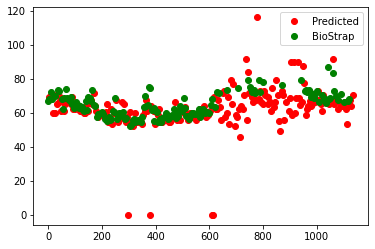

In [24]:
# here we normalize it wrt to the maximum of each beat to see what is the slope:
# well this is fun, I need to come up with the algorithm to normalise it beat by beat
#let's first just scale using the pyheart function:
HR_mean_segment_all = []
hr_seg = []
for kk in num_of_recording_segments:
  #segment plotter function
  #def segment_plotter(seg_number,start_idx,signal):
  #11 16 17 18 19 23 24 26 29 31 33 34 35 36 40
  #seg_number = 40
  seg_number = kk
 
  # here we multiply the the DQM1 to the data:
  DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

  red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)
  start_idx = collect_start_idx
  signal = red_filt_pyheart
  #signal= red_filt_pyheart_DQM_all
  segment_nonscaled = signal[start_idx[seg_number-1]:start_idx[seg_number]]
  segment = hp.scale_data(segment_nonscaled)
  peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
  peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
  #plt.figure(figsize=(10,7))
  #plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
  #plt.plot(segment)
  #plt.plot(peaks_positive,segment[peaks_positive],'oy')
  #plt.plot(peaks_negative,segment[peaks_negative],'or')

  #plt.xlim([0,400])
  #plt.ylim([-100,1050])

  slope_segment_temp = []

  
  time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
  time_segment_length = time_segment[-1] - time_segment[0]
  HR_mean_segment = len(peaks_positive)/time_segment_length
  HR_mean_segment_all = np.append(HR_mean_segment_all,HR_mean_segment)

 
plt.figure()
#plt.plot(HR_mean_segment_all,'or')
#plt.figure(figsize=(20,14))
plt.plot(time[collect_start_idx[1:]],HR_mean_segment_all,'or',label = 'Predicted')
plt.plot(biometrics_data.minute_of_day,HRnp,'og', label = 'BioStrap')
plt.legend()
#plt.ylim([40,90])
plt.show()


next consider the DQM_All for the above plot


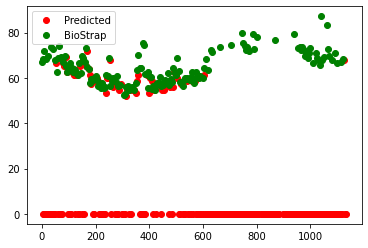

In [25]:
# here we normalize it wrt to the maximum of each beat to see what is the slope:
# well this is fun, I need to come up with the algorithm to normalise it beat by beat
#let's first just scale using the pyheart function:
HR_mean_segment_all = []
hr_seg = []
for kk in num_of_recording_segments:
  #segment plotter function
  #def segment_plotter(seg_number,start_idx,signal):
  #11 16 17 18 19 23 24 26 29 31 33 34 35 36 40
  #seg_number = 40
  seg_number = kk
 
  # here we multiply the the DQM1 to the data:
  DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

  red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)
  start_idx = collect_start_idx
  #signal = red_filt_pyheart
  signal= red_filt_pyheart_DQM_all
  segment_nonscaled = signal[start_idx[seg_number-1]:start_idx[seg_number]]
  segment = hp.scale_data(segment_nonscaled)
  peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
  peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
  #plt.figure(figsize=(10,7))
  #plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
  #plt.plot(segment)
  #plt.plot(peaks_positive,segment[peaks_positive],'oy')
  #plt.plot(peaks_negative,segment[peaks_negative],'or')

  #plt.xlim([0,400])
  #plt.ylim([-100,1050])

  slope_segment_temp = []

  
  time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
  time_segment_length = time_segment[-1] - time_segment[0]
  HR_mean_segment = len(peaks_positive)/time_segment_length
  HR_mean_segment_all = np.append(HR_mean_segment_all,HR_mean_segment)

 
plt.figure()
#plt.plot(HR_mean_segment_all,'or')
#plt.figure(figsize=(20,14))
plt.plot(time[collect_start_idx[1:]],HR_mean_segment_all,'or',label = 'Predicted')
plt.plot(biometrics_data.minute_of_day,HRnp,'og', label = 'BioStrap')
plt.legend()
#plt.ylim([40,90])
plt.show()


next is the buidling the conflict plot based on the DQM_all 

conflict graph
 when bio strap is DQM = 1 it's 1, in agreement DQM = 0, not in agreement ,DQM = -1


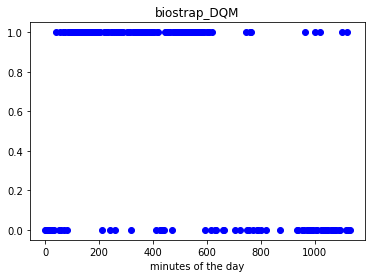

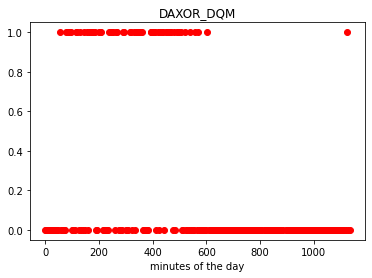

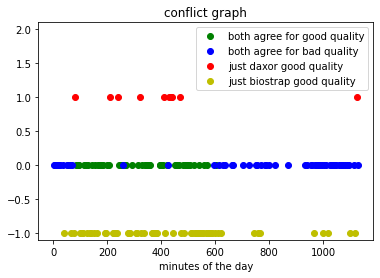

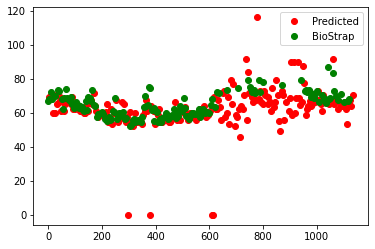

In [26]:
# the first thing that we do here is actually the following, plotting the confilct plot
# here we normalize it wrt to the maximum of each beat to see what is the slope:
time_minute = biometrics_data.minute_of_day
HR = biometrics_data.bpm.to_numpy()
brpm = biometrics_data.brpm.to_numpy()
spo2 = biometrics_data.spo2.to_numpy()
hrv = biometrics_data.hrv.to_numpy()

#print(np.isnan(biometrics_data))
#HRnp = HR.to_numpy()
#print(biometrics_data.isnull().sum().sum())
DQM_all_biostrap = (np.multiply(np.multiply(HR,brpm),np.multiply(spo2,hrv))>0)
plt.figure()
plt.plot(biometrics_data.minute_of_day,DQM_all_biostrap,'ob')
plt.title('biostrap_DQM')
plt.xlabel('minutes of the day')
plt.figure()
plt.plot(time[start_idx],DQM_signal_all[start_idx],'or')
plt.title('DAXOR_DQM')
plt.xlabel('minutes of the day')

# interpolate the signal cumsum using the cubic spline
from scipy import interpolate

#tck = interpolate.splrep(biometrics_data.minute_of_day, DQM_all_biostrap, s=0,k =3)
#tck =  scipy.interpolate.CubicSpline(biometrics_data.minute_of_day, DQM_all_biostrap)
tck =  scipy.interpolate.CubicSpline(time[start_idx],DQM_signal_all[start_idx])

#ynew = interpolate.splev(time[start_idx], tck, der=0)

DQM=np.zeros(len(tck(biometrics_data.minute_of_day)))
DQM[np.where(tck(biometrics_data.minute_of_day)>0.5)] = 1


#plt.plot(biometrics_data.minute_of_day, tck(biometrics_data.minute_of_day), 'ob')
#plt.plot(biometrics_data.minute_of_day, DQM, 'ob')

#plt.title('Cubic-spline interpolation of time vector')
#conflict graph
# when bio strap is DQM = 1 it's 1, in agreement DQM = 0, not in agreement 
# DQM = -

#for i in np.arange(0, len(tck(biometrics_data.minute_of_day))-1,1):

agreement_DQM = 1- np.multiply(DQM,DQM_all_biostrap)
agreement_DQM2 = 1- np.multiply(1-DQM,1-DQM_all_biostrap)

agreement_DQM [agreement_DQM>0.5] = np.nan
agreement_DQM2 [agreement_DQM2>0.5] = np.nan

minute_of_day=biometrics_data.minute_of_day
minute_of_day_agree_idx1 = minute_of_day[agreement_DQM<0.5]
minute_of_day_agree_idx2 = minute_of_day[DQM> DQM_all_biostrap]
minute_of_day_agree_idx3 = minute_of_day[DQM< DQM_all_biostrap]
minute_of_day_agree_idx4 = minute_of_day[agreement_DQM2<0.5]

#print(minute_of_day)
#print(agreement_DQM(minute_of_day_agree_idx))
plt.figure()
# plotting the agreement with zero
plt.plot(minute_of_day_agree_idx1,agreement_DQM[agreement_DQM<0.5],'og')
plt.plot(minute_of_day_agree_idx4,agreement_DQM2[agreement_DQM2<0.5],'ob')
plt.plot(minute_of_day_agree_idx2,DQM[DQM> DQM_all_biostrap],'or')
plt.plot(minute_of_day_agree_idx3,DQM_all_biostrap[DQM< DQM_all_biostrap] - 2,'oy')

#plt.plot(agreement_DQM,'ob')
plt.title('conflict graph')
plt.xlabel('minutes of the day')
#plt.xlim([700,800])
plt.ylim([-1.1,2.1])

plt.legend(['both agree for good quality','both agree for bad quality','just daxor good quality','just biostrap good quality'])

HR_mean_segment_all = []
hr_seg = []
for kk in num_of_recording_segments:
  #segment plotter function
  #def segment_plotter(seg_number,start_idx,signal):
  #11 16 17 18 19 23 24 26 29 31 33 34 35 36 40
  #seg_number = 40
  seg_number = kk
 
  # here we multiply the the DQM1 to the data:
  DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

  red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)
  start_idx = collect_start_idx
  signal = red_filt_pyheart
  #signal= red_filt_pyheart_DQM_all
  segment_nonscaled = signal[start_idx[seg_number-1]:start_idx[seg_number]]
  segment = hp.scale_data(segment_nonscaled)
  peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
  peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
  #plt.figure(figsize=(10,7))
  #plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
  #plt.plot(segment)
  #plt.plot(peaks_positive,segment[peaks_positive],'oy')
  #plt.plot(peaks_negative,segment[peaks_negative],'or')

  #plt.xlim([0,400])
  #plt.ylim([-100,1050])

  slope_segment_temp = []

  
  time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
  time_segment_length = time_segment[-1] - time_segment[0]
  HR_mean_segment = len(peaks_positive)/time_segment_length
  HR_mean_segment_all = np.append(HR_mean_segment_all,HR_mean_segment)

 
plt.figure()
#plt.plot(HR_mean_segment_all,'or')
#plt.figure(figsize=(20,14))
plt.plot(time[collect_start_idx[1:]],HR_mean_segment_all,'or',label = 'Predicted')
plt.plot(biometrics_data.minute_of_day,HRnp,'og', label = 'BioStrap')
plt.legend()
#plt.ylim([40,90])
plt.show()


Next is identfiying the inflection point in the signal

ploting the HRV and the poincare for each segment


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


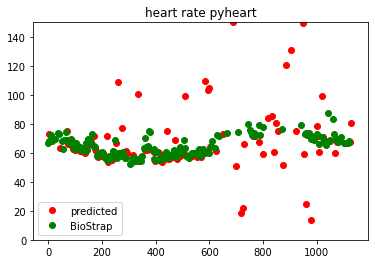

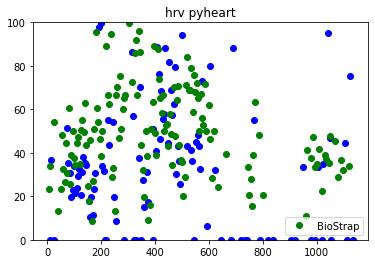

[143.21925213   0.          36.86534918          nan   0.
          nan          nan          nan          nan          nan
          nan          nan          nan 189.4036021   51.59937002
  35.33139584  30.55887332  19.58487112  22.94732604  34.14518319
  21.4867613   23.88166707  29.24357579  32.5251613   20.6366164
  31.02888163  38.27432828  35.09047476  34.58178958          nan
  18.07035413  10.26176486  19.71387674  11.30088264  23.34524177
  30.70548911 145.46587917 118.08464694  97.70881128  99.52214275
  34.10271733  31.84978213   0.           0.          55.26216551
  43.45565744 115.74664573 118.52072807  54.16239258  19.6735297
   8.50340136 326.14749573 125.68503911 140.4536793  119.29638731
 121.21150495   0.         102.31462243 113.22787057          nan
          nan          nan  86.36710153  56.85773471   0.
   0.         327.9711863   37.63508645  70.44491959   0.
  27.71534935  15.0485855           nan  31.26599353  17.48666764
          nan          nan  51.13185

In [27]:
HR_segment_all_pyheart = []
hr_seg_pyheart = []
hrv_segment_pyheart = []
#num_of_recording_segments = [11]
for kk in num_of_recording_segments:
  #segment plotter function
  #def segment_plotter(seg_number,start_idx,signal):
  #11 16 17 18 19 23 24 26 29 31 33 34 35 36 40
  #seg_number = 40
  seg_number = kk
  #print(kk)
  # here we multiply the the DQM1 to the data:
  DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)
  red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)

  start_idx = collect_start_idx

  #signal = red_filt
  signal = red_filt_pyheart 
  #signal= red_filt_pyheart_DQM_all 
  segment_nonscaled = signal[start_idx[seg_number-1]:start_idx[seg_number]]
  #segment_nonscaled = segment_nonscaled + np.abs(np.amin(segment_nonscaled))
  segment = hp.scale_data(segment_nonscaled)
  #segment = segment + np.abs(np.amin(segment))

  resampled_data = resample(segment[5:len(segment)-5], len(segment[5:len(segment)-5]) * 4)

  #wd, m = hp.process(resampled_data, 4*42, bpmmin=1, bpmmax=210,reject_segmentwise=False, high_precision = True)
  wd, m = hp.process(resampled_data, 4*42, bpmmin= -1, bpmmax=210)

  #wd, m = hp.process_segmentwise(resampled_data, 4*42, segment_width=120, segment_overlap=0.5, mode = 'fast', replace_outliers = True)
  #visualise in plot of custom size
  #plt.figure(figsize=(12,4))
  #hp.plotter(wd, m)
  #plt.xlim([6270,6280])
  bpm=  m['bpm']
  sd1=  m['sd1']
  sd2=  m['sd2']
  breathingrate=  m['breathingrate']
  HR_segment_all_pyheart = np.append(HR_segment_all_pyheart,bpm)
  hrv_segment_pyheart = np.append(hrv_segment_pyheart,sd1)

  #display computed measures
  #print(m.keys())
  #for measure in m.keys():
   # print('%s: %f' %(measure, m[measure])
plt.figure()
plt.title('heart rate pyheart')
plt.plot(time[collect_start_idx[1:]],HR_segment_all_pyheart,'or',label ='predicted')
plt.plot(biometrics_data.minute_of_day,HRnp,'og', label = 'BioStrap')
plt.legend()
#plt.xlim([0,226])
plt.ylim([0,150])
plt.figure()
plt.title('hrv pyheart')
plt.plot(time[collect_start_idx[1:]],hrv_segment_pyheart,'ob')
plt.plot(biometrics_data.minute_of_day,HRVnp,'og', label = 'BioStrap')
plt.legend()
plt.ylim([0,100])
plt.show()
print(hrv_segment_pyheart)


nonlinear poincare measures:
sd1: 0.000000
sd2: 0.000000
s: 0.000000
sd1/sd2: nan


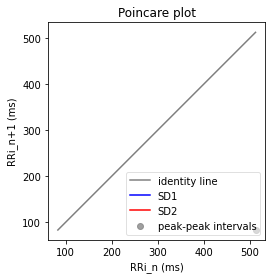

In [28]:
hp.plot_poincare(wd, m)

#print poincare measures
poincare_measures = ['sd1', 'sd2', 's', 'sd1/sd2']
print('\nnonlinear poincare measures:')
for measure in poincare_measures:
    print('%s: %f' %(measure, m[measure]))

finding the inflection point


(array([  32,   48,   49,   82,  115,  130,  173,  179,  188,  194,  232,
        274,  278,  289,  290,  328,  338,  369,  419,  425,  469,  525,
        526,  527,  534,  570,  571,  572,  606,  646,  652,  710,  711,
        712,  746,  773,  816,  912,  936,  957,  963,  977,  985, 1011,
       1125, 1186, 1196, 1231, 1277, 1288, 1289, 1332, 1336, 1379, 1428,
       1429, 1430, 1473, 1474, 1475, 1509, 1607, 1610, 1717, 1789, 1793,
       1800, 1843, 1922, 1929, 1930, 1931]),)
[  25   32   46   47   48   49   50   77   82   83   92   93   94  104
  115  125  130  140  141  142  143  173  179  188  189  192  193  194
  195  205  232  253  264  274  278  288  289  290  291  328  338  341
  342  369  376  398  419  425  464  469  479  480  515  524  525  526
  527  534  554  560  569  570  571  572  580  601  606  646  652  663
  664  710  711  712  719  730  746  773  789  816  827  832  833  874
  891  912  918  936  947  957  963  972  973  977  985 1011 1028 1055
 1092 1097 1125 11

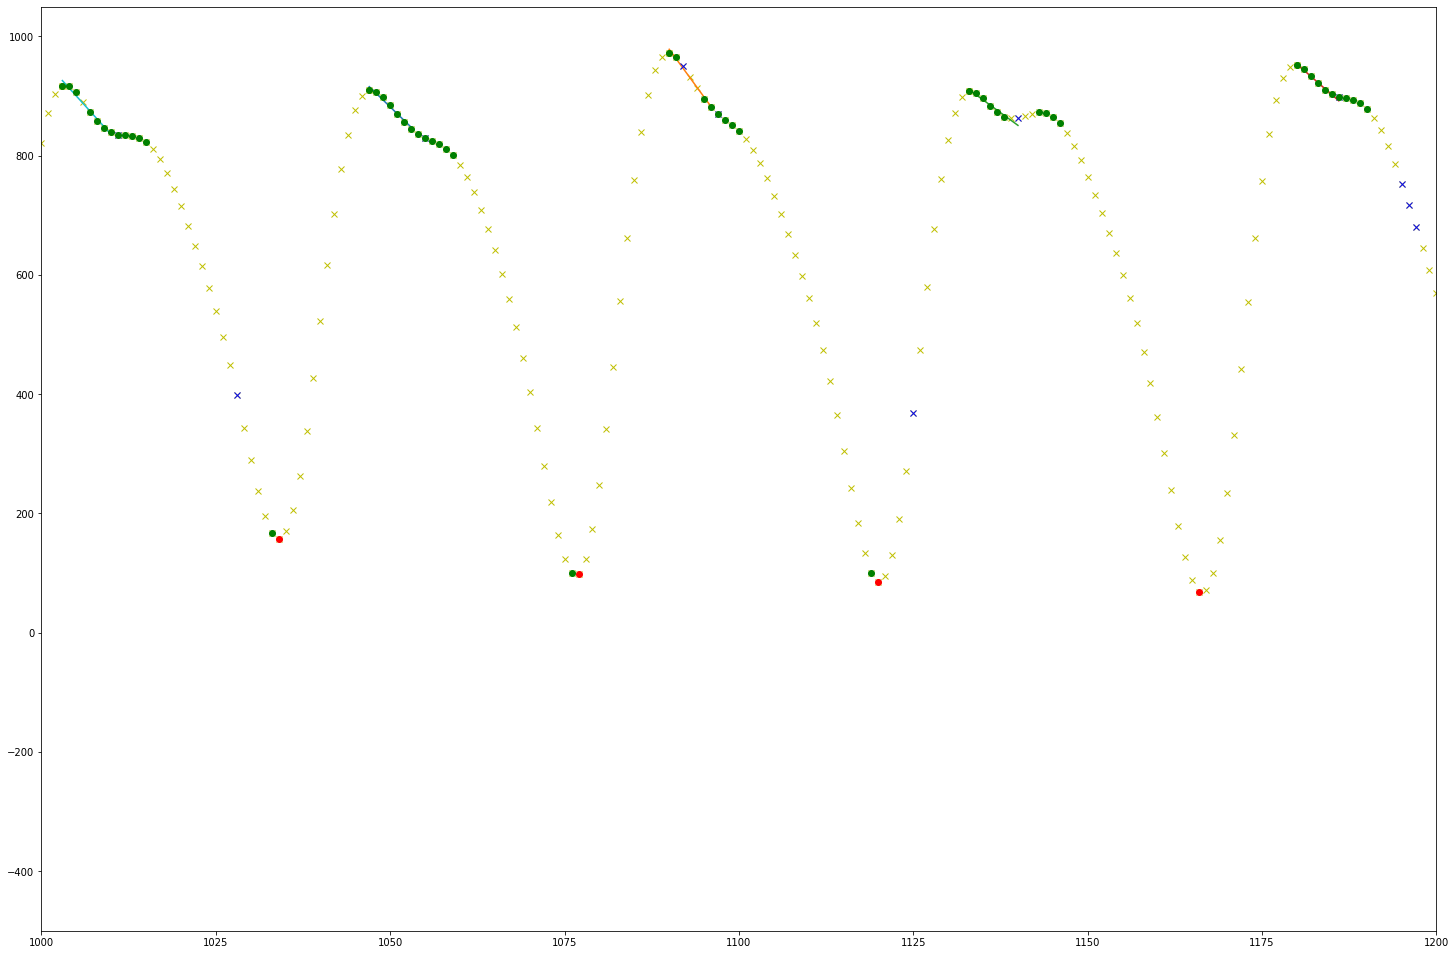

mean slope for the segment:
-12.466478013332186
Heart rate for the segment
54.75426983888005
Slope normalized by Heart rate for the segment
-22.768047222647752


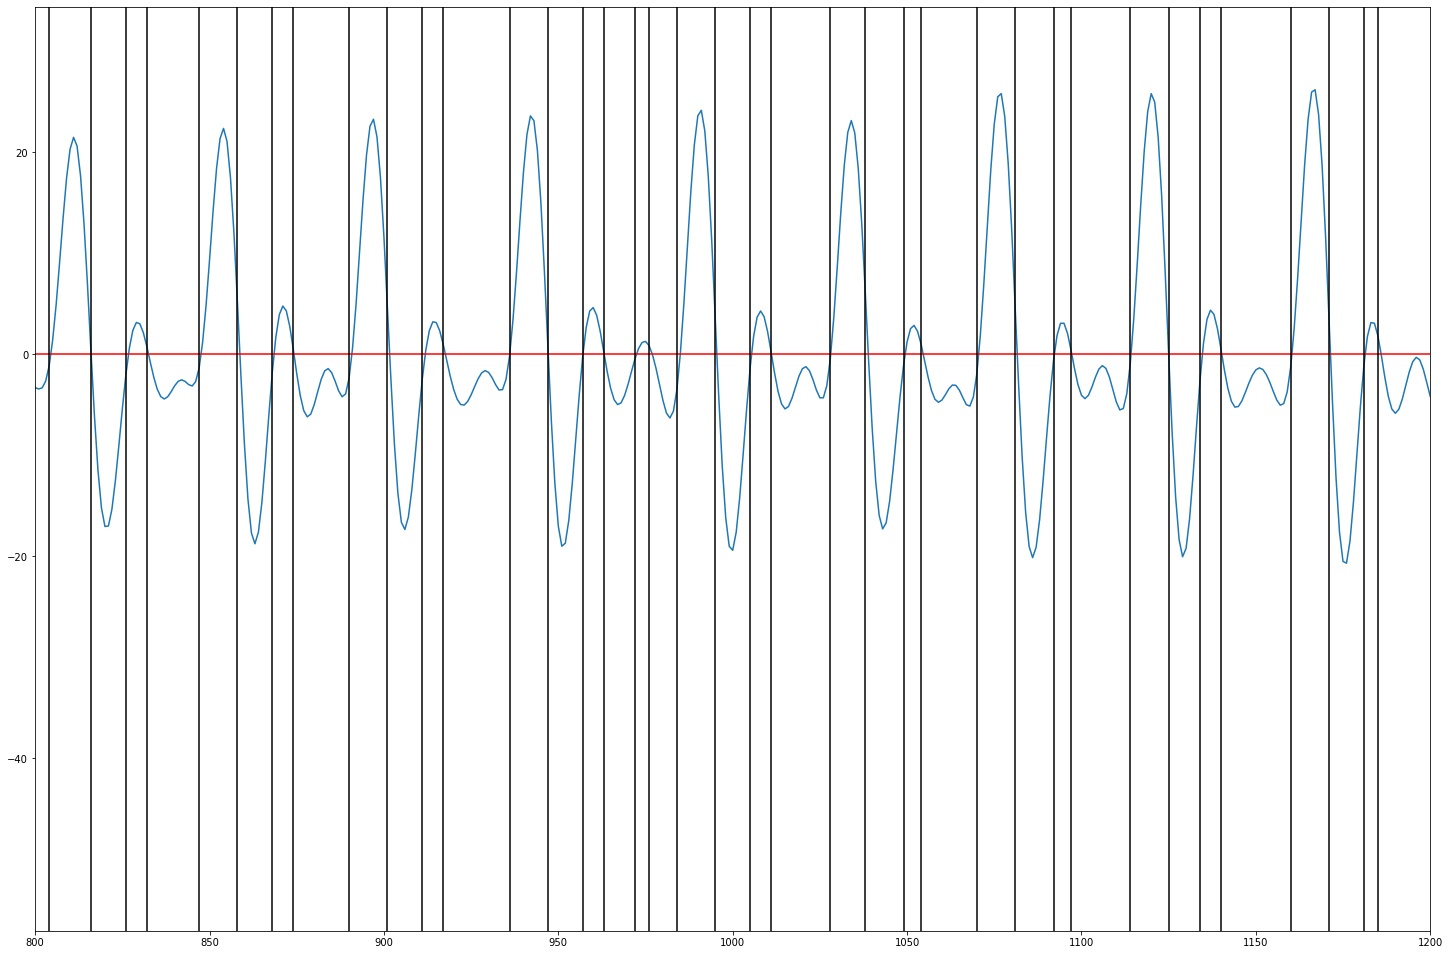

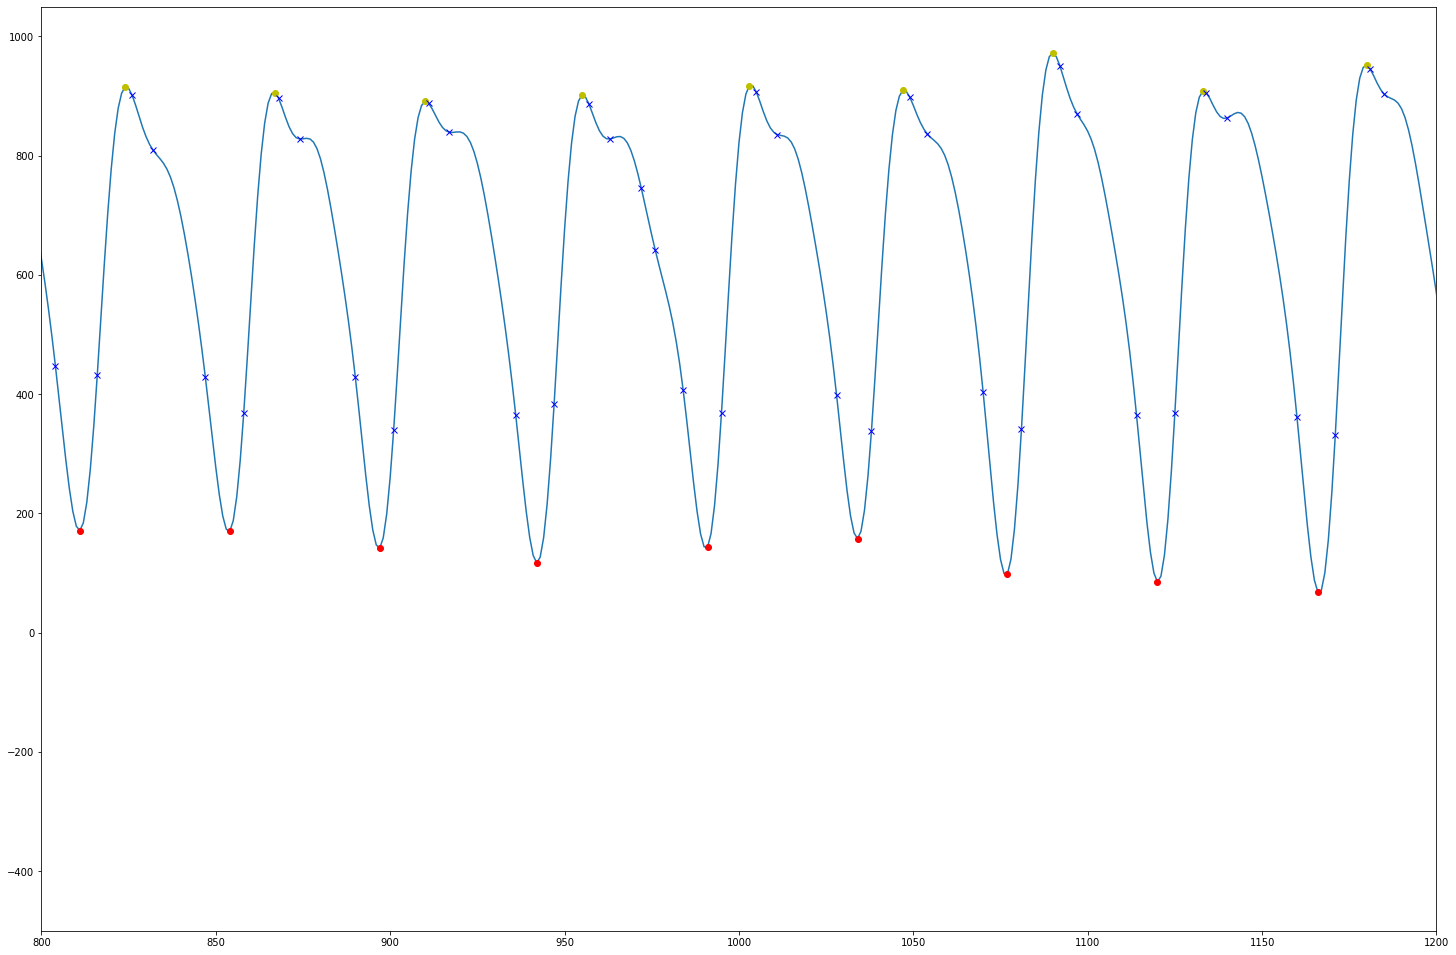

In [29]:
# here we normalize it wrt to the maximum of each beat to see what is the slope:
# well this is fun, I need to come up with the algorithm to normalise it beat by beat
#let's first just scale using the pyheart function:
from numpy.core.defchararray import multiply
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
#11 16 17 18 19 23 24 26 29 31 33 34 35 36 40
seg_number =90

# here we multiply the the DQM1 to the data:
DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)
start_idx = collect_start_idx
#signal = red_filt_pyheart
signal= red_filt_pyheart_DQM_all
segment_nonscaled = signal[start_idx[seg_number-1]:start_idx[seg_number]]
segment = hp.scale_data(segment_nonscaled)
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
plt.figure(figsize=(25,17))
#plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(segment,'yx')
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([1000,1200])
plt.ylim([-500,1050])
slope_segment_temp = []

# here we start from the third element of the segment to the last -4
for i in np.arange(3,len(peaks_positive)-4, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    #print( slope_up)
    #print( slope_up_idx)
    if len(slope_up_idx) == 0:
      continue
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  slope_segment_temp  = np.append(slope_segment_temp,slope)
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
derivative1= np.diff(segment, axis=0)
derivative2= np.diff(derivative1, axis=0)


#print(np.where((np.abs(derivative1)<0.4)))

print(np.where((np.abs(derivative2)<0.4)))
idx_temp =np.where((np.abs(derivative2)<0.8)) [0]
#idx_temp = np.asarray(idx_temp)
print(idx_temp)
type(idx_temp)
plt.plot(idx_temp,segment[idx_temp],'xb')
# using the first derivative to be negative and small to filter out some points
derivative1neg = derivative1
# we are interested in low absoulute negetive slopes so here we artificially changing the postive derivatives to a very negative value, 
derivative1neg[derivative1neg>0] =-1000 
idx_temp2 =np.where((derivative1neg)>-17)
idx_temp2 = np.asarray(idx_temp2)
plt.plot(idx_temp2,segment[idx_temp2],'og')

print(derivative1neg)
print(np.max(derivative1neg))
plt.show()
print('mean slope for the segment:')
print(np.mean(slope_segment_temp))
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print('Heart rate for the segment')
print(HR_mean_segment)
print('Slope normalized by Heart rate for the segment')
print(np.mean(slope_segment_temp)/HR_mean_segment*100)

plt.figure(figsize=(25,17))
plt.plot(derivative2)
plt.axhline(y = 0, color = 'r', linestyle = '-')
#plt.ylim([-20,20])
plt.xlim([800,1200])
# find switching points
infls = np.where(np.diff(np.sign(derivative2)))[0]
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
#plt.legend(bbox_to_anchor=(1.55, 1.0))
plt.figure(figsize=(25,17))

# find switching points
infls = np.where(np.diff(np.sign(derivative2)))[0]
plt.plot(segment)
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([800,1200])
plt.ylim([-500,1050])
plt.plot(infls,segment[infls],'xb')
plt.show()


now I need to actually come up with a way to easily distinguish between the mutiple zero crossing, I can rule so each beat has either 4 zero points or 6 zero points. I can go ahead and rule out half of them, one way is jus see where is the peak and the next negetive peak any thing negative to positive switching come out after the the peak and before the negative could be our point. let's identify these dicortic notches this way.
 

(array([  23,   75,  120,  165,  169,  190,  191,  225,  314,  382,  404,
        450,  501,  540,  555,  597,  623,  650,  697,  700,  717,  720,
        748,  753,  765,  766,  767,  768,  799,  803,  817,  818,  840,
        853,  854,  904,  945,  947,  994, 1005, 1007, 1039, 1042, 1126,
       1137, 1140, 1176, 1188, 1192, 1213, 1236, 1237, 1279, 1282, 1303,
       1361, 1474, 1475, 1476, 1510, 1551, 1553, 1597, 1611, 1643, 1644,
       1678, 1690, 1691, 1692, 1735, 1779, 1824, 1865, 1868, 1913, 1923]),)
[  23   29   75   86  116  120  165  169  177  178  179  189  190  191
  192  210  225  246  272  283  292  303  314  317  318  363  382  404
  408  446  450  451  467  498  499  500  501  513  514  515  516  540
  551  555  574  597  600  601  623  650  697  698  699  700  701  717
  718  719  720  727  748  753  764  765  766  767  768  799  803  816
  817  818  819  840  852  853  854  855  866  867  868  878  904  915
  916  945  946  947  990  994 1005 1006 1007 1008 1039 104

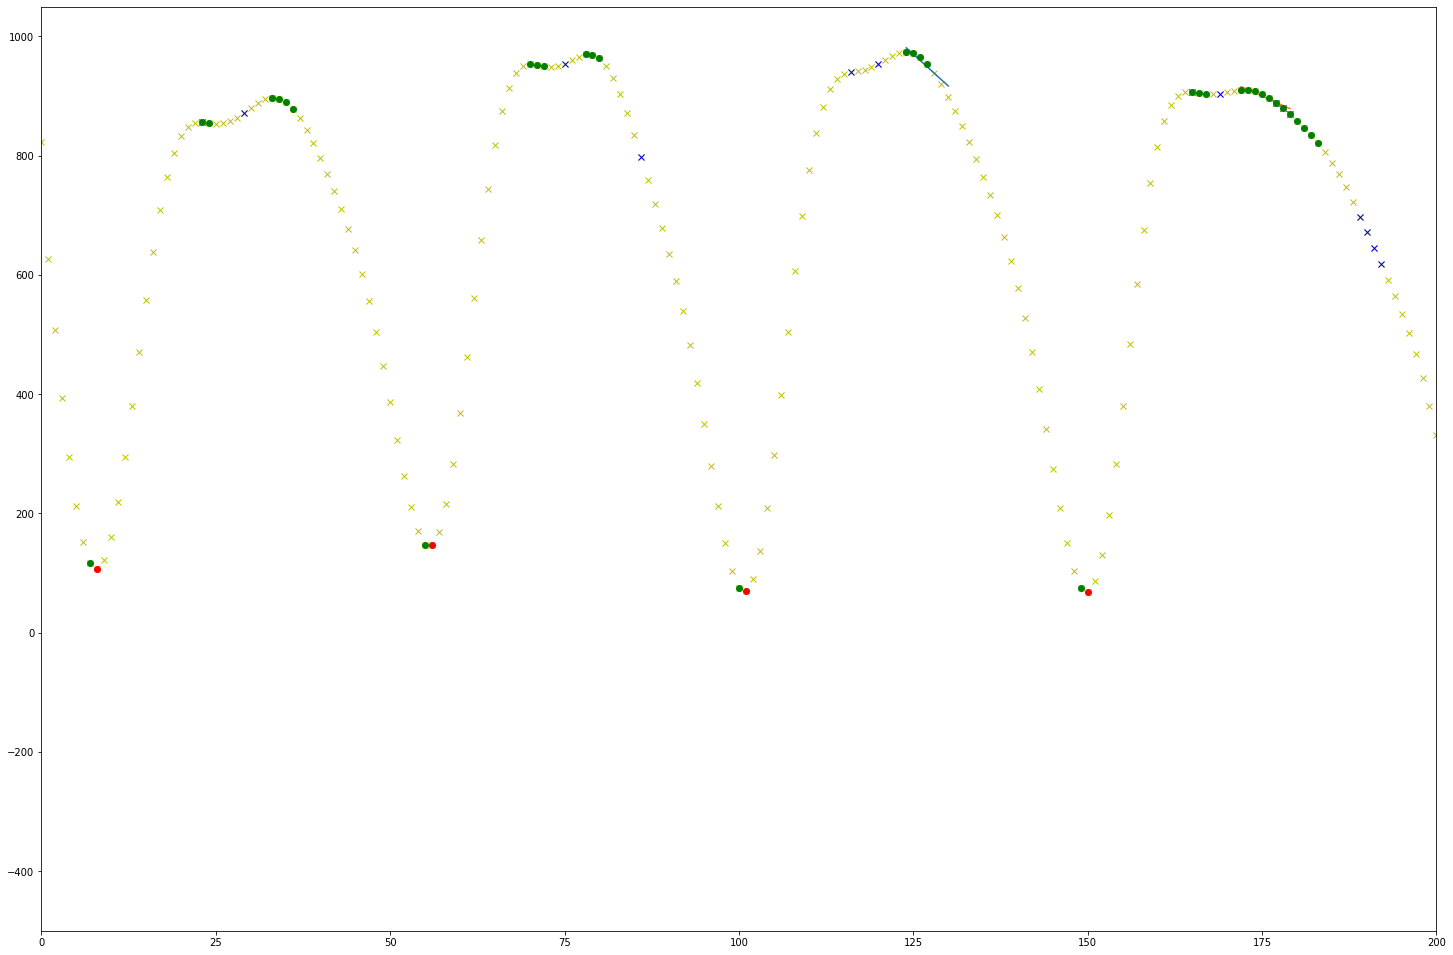

mean slope for the segment:
-6.118015724544426
Heart rate for the segment
53.450596747478144
Slope normalized by Heart rate for the segment
-11.446113040511714


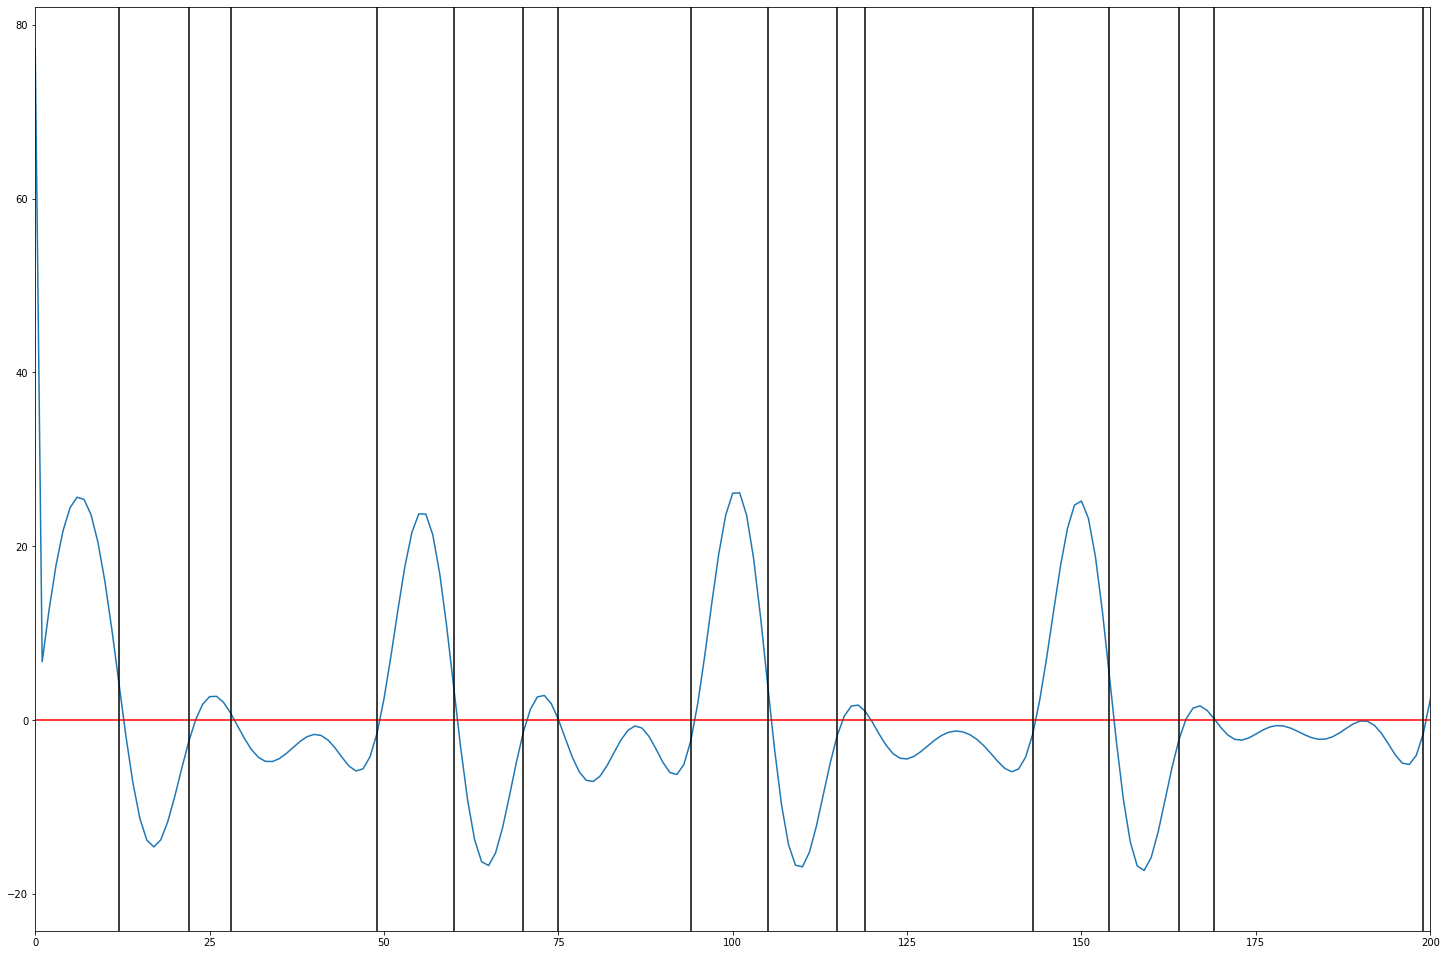

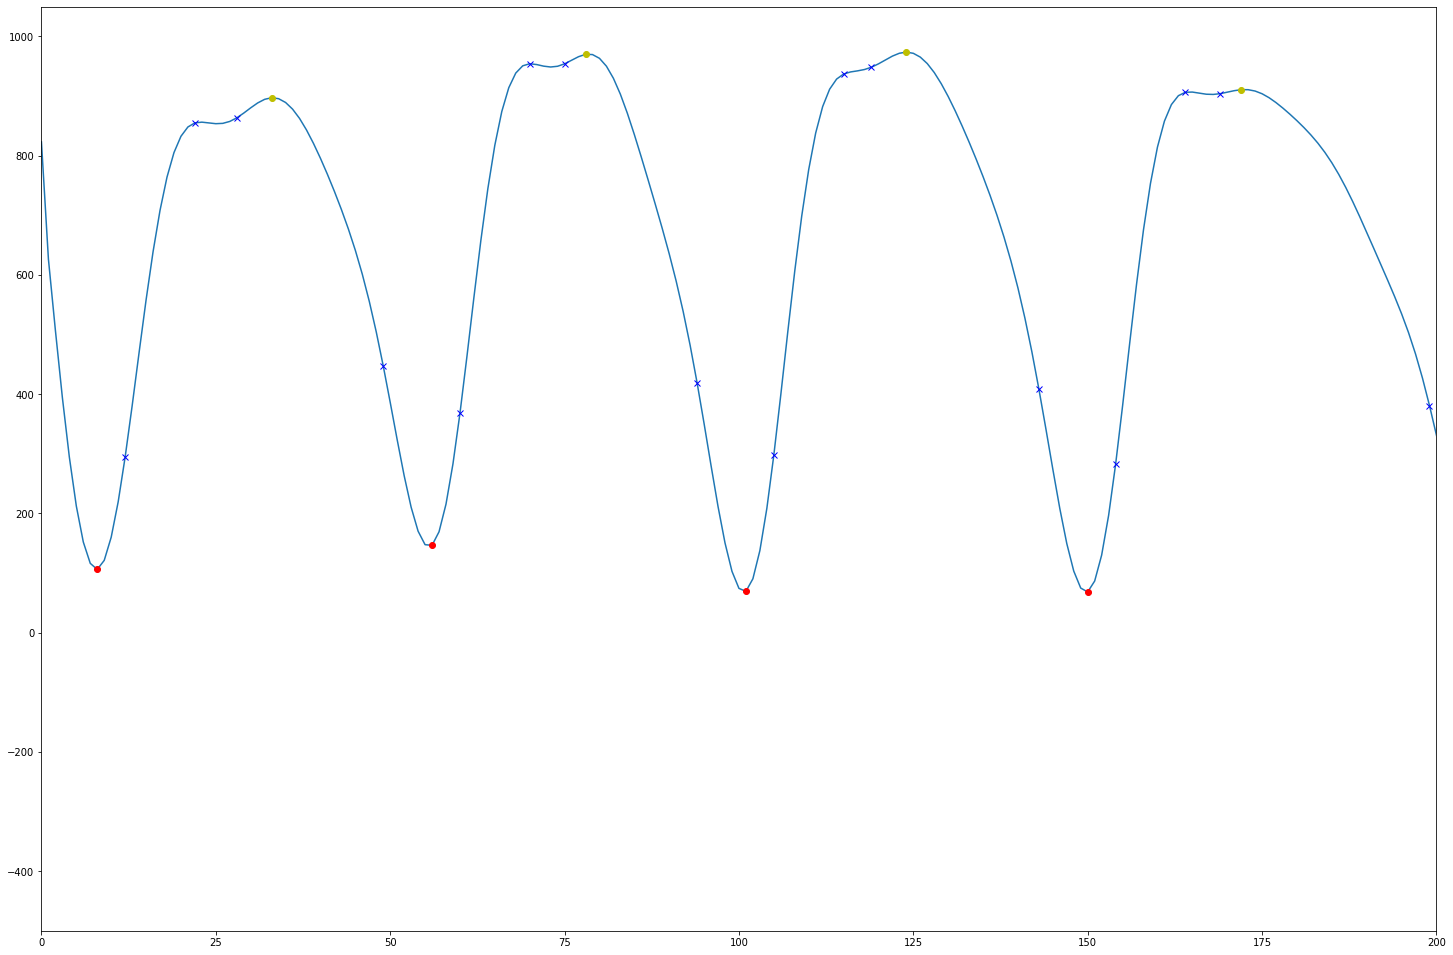

[  33   78  124  172  219  275  313  358  403  455  504  549  604  653
  696  757  808  851  900  950  997 1039 1097 1144 1186 1234 1278 1325
 1371 1413 1458 1504 1550 1600 1641 1688 1732 1776 1821 1871 1905]
[   8   56  101  150  205  252  298  343  388  431  483  535  581  630
  681  733  784  835  884  929  974 1023 1073 1121 1171 1219 1263 1309
 1356 1398 1442 1490 1535 1579 1625 1673 1716 1760 1806 1849 1892]
[  12   22   28   49   60   70   75   94  105  115  119  143  154  164
  169  199  210  220  225  246  257  267  271  291  303  314  317  336
  348  358  362  381  393  403  407  424  435  446  450  476  487  498
  501  528  539  550  555  574  585  596  600  623  634  645  649  674
  685  696  700  717  720  727  737  747  753  765  767  777  788  798
  803  828  839  878  889  900  904  923  934  945  947  967  978  989
  993 1004 1007 1016 1027 1039 1042 1067 1078 1089 1092 1114 1126 1137
 1139 1164 1176 1187 1191 1212 1224 1257 1268 1279 1282 1302 1314 1349
 1360 1391 140

In [30]:
# here we normalize it wrt to the maximum of each beat to see what is the slope:
# well this is fun, I need to come up with the algorithm to normalise it beat by beat
#let's first just scale using the pyheart function:
from numpy.core.defchararray import multiply
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
#11 16 17 18 19 23 24 26 29 31 33 34 35 36 40
seg_number =80

# here we multiply the the DQM1 to the data:
DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)
start_idx = collect_start_idx
#signal = red_filt_pyheart
signal= red_filt_pyheart_DQM_all
segment_nonscaled = signal[start_idx[seg_number-1]:start_idx[seg_number]]
segment = hp.scale_data(segment_nonscaled)
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
plt.figure(figsize=(25,17))
#plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(segment,'yx')
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,200])
plt.ylim([-500,1050])
slope_segment_temp = []

# here we start from the third element of the segment to the last -4
for i in np.arange(3,len(peaks_positive)-4, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    #print( slope_up)
    #print( slope_up_idx)
    if len(slope_up_idx) == 0:
      continue
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  slope_segment_temp  = np.append(slope_segment_temp,slope)
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
derivative1= np.diff(segment, axis=0)
derivative2= np.diff(derivative1, axis=0)


#print(np.where((np.abs(derivative1)<0.4)))

print(np.where((np.abs(derivative2)<0.4)))
idx_temp =np.where((np.abs(derivative2)<0.8)) [0]
#idx_temp = np.asarray(idx_temp)
print(idx_temp)
type(idx_temp)
plt.plot(idx_temp,segment[idx_temp],'xb')
# using the first derivative to be negative and small to filter out some points
derivative1neg = derivative1
# we are interested in low absoulute negetive slopes so here we artificially changing the postive derivatives to a very negative value, 
derivative1neg[derivative1neg>0] =-1000 
idx_temp2 =np.where((derivative1neg)>-17)
idx_temp2 = np.asarray(idx_temp2)
plt.plot(idx_temp2,segment[idx_temp2],'og')

print(derivative1neg)
print(np.max(derivative1neg))
plt.show()
print('mean slope for the segment:')
print(np.mean(slope_segment_temp))
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print('Heart rate for the segment')
print(HR_mean_segment)
print('Slope normalized by Heart rate for the segment')
print(np.mean(slope_segment_temp)/HR_mean_segment*100)

plt.figure(figsize=(25,17))
plt.plot(derivative2)
plt.axhline(y = 0, color = 'r', linestyle = '-')
#plt.ylim([-20,20])
plt.xlim([0,200])
# find switching points
infls = np.where(np.diff(np.sign(derivative2)))[0]
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
#plt.legend(bbox_to_anchor=(1.55, 1.0))
plt.figure(figsize=(25,17))

# find switching points
infls = np.where(np.diff(np.sign(derivative2)))[0]
plt.plot(segment)
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,200])
plt.ylim([-500,1050])
plt.plot(infls,segment[infls],'xb')
plt.show()
print(peaks_positive)
print(peaks_negative)
print(infls)



now when I have this nice and smooth second derivative for this signal I can do many things with this
- I  can see where it crosses zero and that's my dicrotic notch
refer to 
- for the dimension difference of the array of diff(diff(signal)) I can resample, interpolate and I can do almost everthing

now I need to remove the low absolute value of negative slope points near the peaks..

The following could be done to dynamically change the treshold of every beats:
- checking every positvie peak to negative peak and look for the least negative slope in union of the least second dervative 



(array([   7,   33,   42,   73,  131,  133,  217,  219,  266,  286,  333,
        350,  391,  495,  536,  569,  598,  608,  653,  663,  664,  671,
        705,  706,  707,  835,  869,  875,  915, 1054, 1074, 1095, 1099,
       1141, 1149, 1150, 1176, 1222, 1231, 1232, 1258, 1264, 1298, 1304,
       1343, 1369, 1412, 1427, 1439, 1503, 1508, 1556, 1557, 1589, 1668,
       1702, 1707, 1715, 1716, 1783, 1879, 1880, 1920]),)
[[   7   33   42   47   73   87   90   91  122  131  132  133  165  174
   177  183  217  218  219  251  266  286  318  328  333  342  343  350
   384  385  391  411  491  495  536  549  569  575  598  608  653  663
   664  671  705  706  707  732  738  746  774  779  794  835  868  869
   870  875  895  901  915  975  980 1014 1020 1054 1074 1095 1099 1115
  1141 1149 1150 1151 1156 1176 1189 1197 1222 1230 1231 1232 1258 1264
  1278 1298 1304 1317 1343 1369 1412 1421 1427 1435 1439 1503 1508 1533
  1543 1548 1556 1557 1558 1564 1589 1602 1629 1668 1702 1707 1715 1716


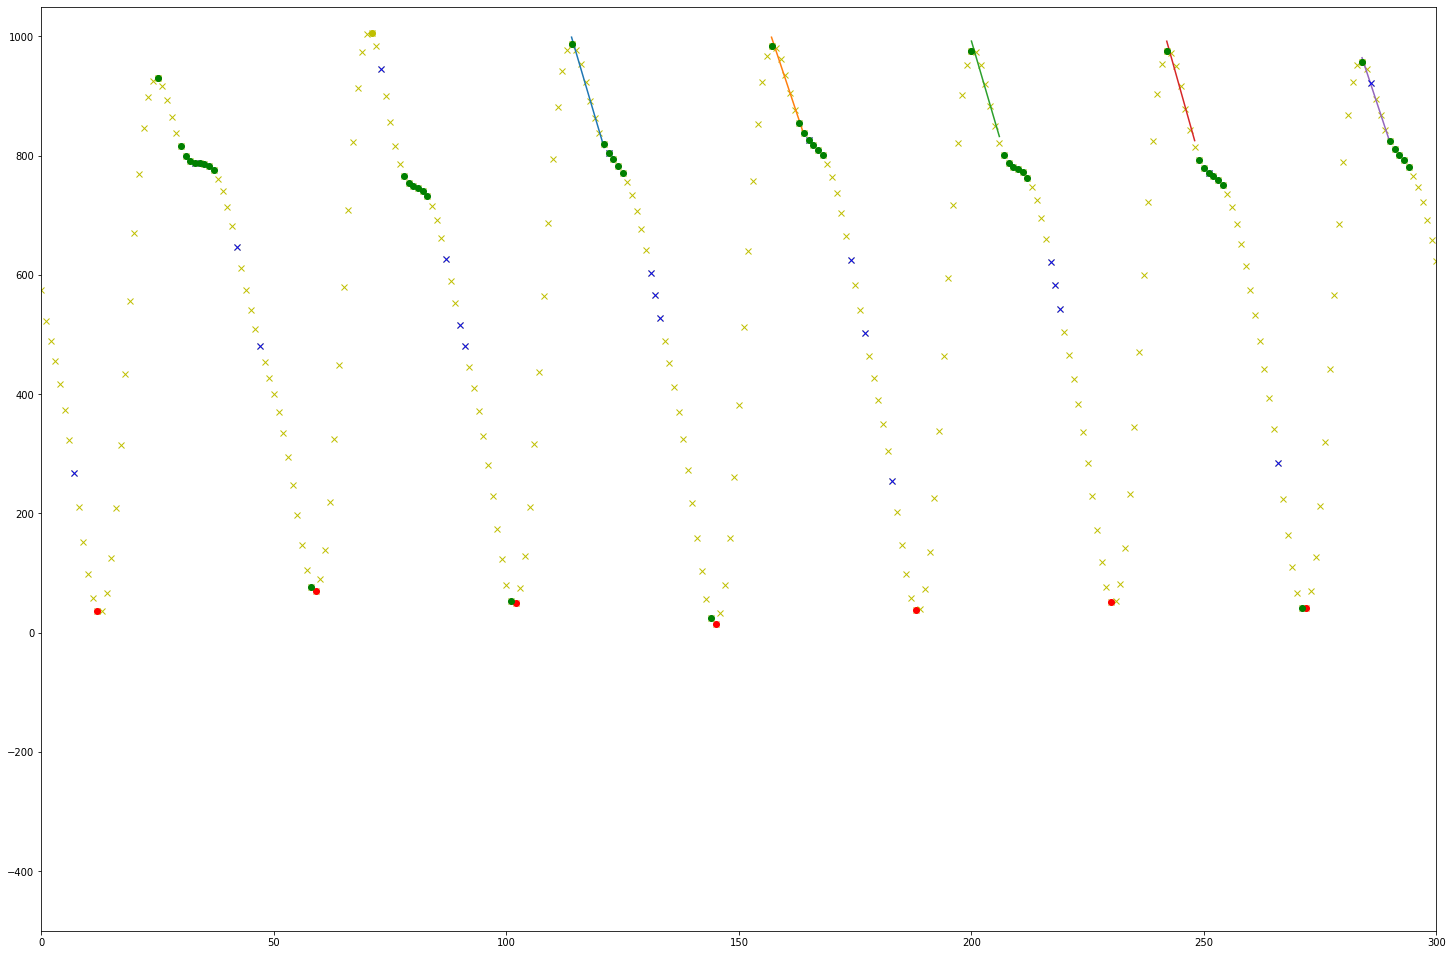

mean slope for the segment:
-25.125070497874347
Heart rate for the segment
61.27263529588958
Slope normalized by Heart rate for the segment
-41.00536948760851


In [35]:
# here we normalize it wrt to the maximum of each beat to see what is the slope:
# well this is fun, I need to come up with the algorithm to normalise it beat by beat
#let's first just scale using the pyheart function:
from numpy.core.defchararray import multiply
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
#11 16 17 18 19 23 24 26 29 31 33 34 35 36 40
seg_number =72
# here we multiply the the DQM1 to the data:
DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

red_filt_pyheart_DQM_all = np.multiply(red_filt_pyheart,DQM_signal_all)
start_idx = collect_start_idx
#signal = red_filt_pyheart
signal= red_filt_pyheart_DQM_all
segment_nonscaled = signal[start_idx[seg_number-1]:start_idx[seg_number]]
segment = hp.scale_data(segment_nonscaled)
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
plt.figure(figsize=(25,17))
#plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(segment,'yx')
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,300])
plt.ylim([-500,1050])
slope_segment_temp = []

# here we start from the third element of the segment to the last -4
for i in np.arange(3,len(peaks_positive)-3, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    #print( slope_up)
    #print( slope_up_idx)
    if len(slope_up_idx) == 0:
      continue
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  slope_segment_temp  = np.append(slope_segment_temp,slope)
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
derivative1= np.diff(segment, axis=0)
derivative2= np.diff(derivative1, axis=0)


#print(np.where((np.abs(derivative1)<0.4)))

print(np.where((np.abs(derivative2)<0.4)))
idx_temp =np.where((np.abs(derivative2)<0.8)) 
idx_temp = np.asarray(idx_temp)
print(idx_temp)
type(idx_temp)
plt.plot(idx_temp,segment[idx_temp],'xb')
# using the first derivative to be negative and small to filter out some points
derivative1neg = derivative1
# we are interested in low absoulute negetive slopes so here we artificially changing the postive derivatives to a very negative value, 
derivative1neg[derivative1neg>0] =-1000 
idx_temp2 =np.where((derivative1neg)>-17)
idx_temp2 = np.asarray(idx_temp2)
plt.plot(idx_temp2,segment[idx_temp2],'og')

print(derivative1neg)
print(np.max(derivative1neg))
plt.show()
print('mean slope for the segment:')
print(np.mean(slope_segment_temp))
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print('Heart rate for the segment')
print(HR_mean_segment)
print('Slope normalized by Heart rate for the segment')
print(np.mean(slope_segment_temp)/HR_mean_segment*100)



Let’s look at multiple point inflection points algorithm, and not just two points
I can do almost anything with my algorithm 


the envelope  fluctiontion plot as a function of the day works as a potential metric
* Ineed to fix some small typo in the following code


(array([ 42,  46,  66,  67,  70,  84,  98, 105, 109, 114, 119, 126, 128,
       133, 146, 155, 160, 161, 162, 174, 226]),)
(array([ 16,  17,  18,  32,  72,  75,  86, 108, 110, 120, 140, 154, 158,
       159, 176, 188, 210, 213, 214, 221]),)


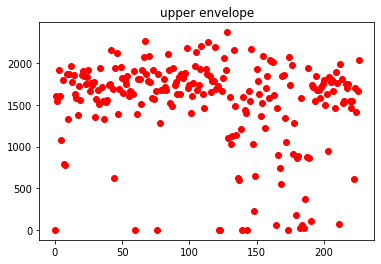

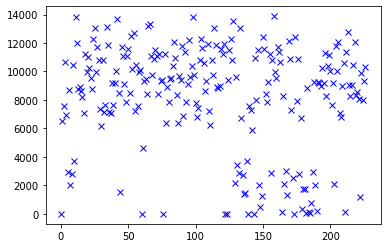

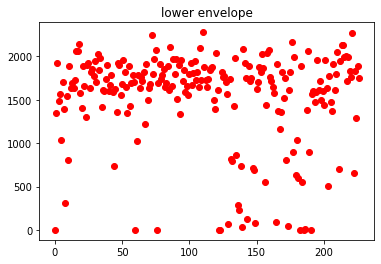

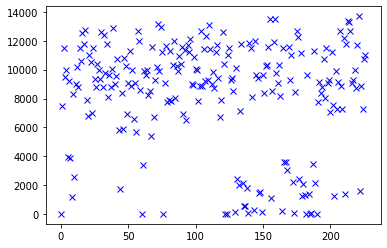

In [32]:
#from numpy.core.fromnumeric import std
#for the envelop of each segment, we just find the peak of the signal and the the reverse signal(signal multiplied * -1) which is basically the mean of the signal
upper_maxmin_segment_vector = np.zeros(recording_episode_counts_total+1)
lower_maxmin_segment_vector = np.zeros(recording_episode_counts_total+1)
upper_envelope_fluctuation =np.zeros(recording_episode_counts_total+1)
lower_envelope_fluctuation =np.zeros(recording_episode_counts_total+1)
for j in num_of_recording_segments:
  
  peaks_positive, _ = find_peaks(red_filt_pyheart[collect_start_idx[j-1]:collect_start_idx[j]], height=0,distance =20)
  peaks_negative, _ = find_peaks(-red_filt_pyheart[collect_start_idx[j-1]:collect_start_idx[j]], height=0,distance =20)
  
  if len(peaks_positive) == 0:
    continue
  if len(peaks_negative) == 0:
    continue
  mean_seg_postive_temp = np.mean(red_filt_pyheart[peaks_positive])
  max_seg_postive_temp = np.max(red_filt_pyheart[peaks_positive])
  min_seg_postive_temp = np.min(red_filt_pyheart[peaks_positive])
  std_seg_postive_temp = np.std(red_filt_pyheart[peaks_positive])
  mean_seg_negative_temp = np.mean(red_filt_pyheart[peaks_negative])
  max_seg_negative_temp = np.max(red_filt_pyheart[peaks_negative])
  min_seg_negative_temp = np.min(red_filt_pyheart[peaks_negative])
  std_seg_negative_temp = np.std(red_filt_pyheart[peaks_negative])
  upper_envelope_fluctuation[j]= std_seg_postive_temp
  lower_envelope_fluctuation[j] = std_seg_negative_temp
  upper_maxmin_segment_vector [j] = max_seg_postive_temp - min_seg_postive_temp
  lower_maxmin_segment_vector [j] =max_seg_negative_temp - min_seg_negative_temp
  #print(j)
  
# extracting the HR beat:
  #hr_interval = np.diff(time[peaks])
  #hr_interval_mean = np.mean(hr_interval)
  #print(time[peaks[-1]]-time[peaks[0]])
  #print(m)
 
  #print(time[peaks[-1]])
  #print(time[peaks[0]])

  #HR_ave [j] = len(peaks)/time_interval_in_min;
a = np.where(upper_envelope_fluctuation>2000)
b = np.where (lower_envelope_fluctuation>2000)
print(a)
print(b)

plt.figure()
plt.plot(upper_envelope_fluctuation, 'or')
plt.title('upper envelope')
plt.figure()
plt.plot(upper_maxmin_segment_vector,'xb')
plt.figure()
plt.title('lower envelope')
plt.plot(lower_envelope_fluctuation, 'or')
plt.figure()
plt.plot(lower_maxmin_segment_vector,'xb')


#print(upper_envelope_fluctuation)

In [33]:
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')


70.39834693570553
Heart rate for the segment


In [34]:
#from scipy.signal import resample

#resample the data. Usually 2, 4, or 6 times is enough depending on original sampling rate
resampled_data = resample(filtered, len(filtered) * 2)

NameError: ignored

Upsampling the signal has enabled HeartPy to optimize and find the position for all peaks in the signal.

Note the use of hp.scale_data() in the processing function. This is recommended when the amplitude is low (2.4-3.8 in the original data).

That works! A quick and dirty automatic extraction of signal sections
For this we use a window function and for each window test whether it:

Has a range that is at least 50% of range of the raw signal
OR
Has a maximum that is 90% the raw signal’s maximum
OR
Has a minimum that is the minimum + 10% of the raw signal
This works well enough